In [1]:
import sys
import os
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
#from scipy.stats import boxcox
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
import math
from sklearn import metrics



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
from sklearn.model_selection import GridSearchCV

from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn import metrics
import cPickle as pickle


plt.style.use('ggplot') 
%matplotlib inline

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).


# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate demographic data and data concerning hospital and ICU stays for patients diagnosed with sepsis. The query was exported from Porticoto the file ADMISSIONS_ICUSTAY_SEPSIS.csv. The data was read into a pandas dataframe ptnt_demog 



## INTEGRATE DATA FROM LABS AND CHARTS
Data from labs and charts have been previously aggregated and summarized (variables with multiple measurements have had mean, std, skewness etc calculated). Data is integrated/merged into a single data_frame. 

## FEATURE SELECTION
Feature selection tools, including SelectKBest, require data sets to be full (no NaN values)and to be of the same type (continuous/categorical). To reduce the dimensionality of our data and select the most relevant features, data is then broken out into blocks according to data type. Because not all data was collected for all icu stays or patients there are gaps such that there are very few icu stays for which there are no NaN values. There were patterns of data collection however, groups of variables that were most often collected together (likely the results of the condition, the type of ICU etc). To generate full sets of data for feature selection, the data is further broken down into blocks of variables most often collected together. 

In [2]:
features_dir = os.getcwd() + '/features/'
#display(features_dir)
monkey = os.listdir(features_dir)
feature_files = [x for x in monkey if '.csv' in x]
features_dict = {}
for name in feature_files:
    print(name)
    features_dict[name.split('.')[0]] = pd.DataFrame.from_csv(features_dir + name)
outcomes = pd.DataFrame.from_csv(features_dir + 'outcomes.csv')

scores = [x for x in features_dict.keys() if 'Scores' in x]
features = [x for x in features_dict.keys() if 'Scores' not in x]
scores.sort()
features.sort()


for i in range(len(scores)):
    if i == 0:
        all_scores = features_dict[scores[i]]
    else:
        all_scores = all_scores.append(features_dict[scores[i]])


all_scores = all_scores.sort_values(by = 'p_values', ascending = True)
top_scores = list(all_scores.head(20).index)
display("all scores")
display(all_scores)
display("top scores")
display(top_scores)

first = True
all_data = outcomes
for frame in features:
    for col in features_dict[frame].columns:
        if col in top_scores:
            
            feat = features_dict[frame][col] 
            all_data = all_data.merge(pd.DataFrame(feat), left_index = True, 
                                     right_index = True, how = 'inner', sort = True)
            
            #display(feat.name)
            #display(all_data.shape)
            
all_data.rename(index=str, columns={"Pneumonia (except that caused by tuberculosis or sexually transmitted disease)": "Pneumonia",
                                         "Respiratory failure; insufficiency; arrest (adult)": "Respiratory Failure"}, 
                     inplace = True)


display(all_data.shape)
           

BP_Features.csv
BP_FeaturesScores.csv
GCS_Features.csv
GCS_FeaturesScores.csv
GCSTotal_Features.csv
GCSTotal_FeaturesScores.csv
HrRr_Features.csv
HrRr_FeaturesScores.csv
Lab_AbnFlag_Features.csv
Lab_AbnFlag_FeaturesScores.csv
Lab_CreatGlucHemWBC_Features.csv
Lab_CreatGlucHemWBC_FeaturesScores.csv
Lab_pHLacO2Sat_Features.csv
Lab_pHLacO2Sat_FeaturesScores.csv
outcomes.csv
Ptnt_Demog_Features.csv
Ptnt_Demog_FeaturesScores.csv


'all scores'

,p_values,scores
Respiratory failure; insufficiency; arrest (adult),0.000000e+00,2225.274059
Shock,0.000000e+00,1861.192748
Septicemia (except in labor),0.000000e+00,1677.322169
Acute and unspecified renal failure,1.041593e-282,1290.960219
icu_stay_Q3,1.409990e-199,908.476155
Other liver diseases,2.017421e-177,806.564644
GCS Total_15,1.700493e-133,604.566409
GCS Total_3,4.209906e-131,593.561335
first_careunit_CSRU,1.364892e-114,517.662500
Fluid and electrolyte disorders,1.471326e-109,494.532004


'top scores'

['Respiratory failure; insufficiency; arrest (adult)',
 'Shock',
 'Septicemia (except in labor)',
 'Acute and unspecified renal failure',
 'icu_stay_Q3',
 'Other liver diseases',
 'GCS Total_15',
 'GCS Total_3',
 'first_careunit_CSRU',
 'Fluid and electrolyte disorders',
 'admission_type_ELECTIVE',
 'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
 'Acute cerebrovascular disease',
 'GCS Total_6',
 'Creat_abnflag',
 'GCS Total_4',
 'RR_mean_Q3',
 'icu_stay_Q0',
 'age_Q3',
 'first_careunit_MICU']

(2665, 21)

In [3]:
cols = list(all_data.columns)
#cols.sort()
for col in cols:
    print col

hospital_expire_flag
GCS Total_15
GCS Total_3
GCS Total_6
GCS Total_4
RR_mean_Q3
Creat_abnflag
Respiratory Failure
Shock
Septicemia (except in labor)
Acute and unspecified renal failure
icu_stay_Q3
Other liver diseases
first_careunit_CSRU
Fluid and electrolyte disorders
admission_type_ELECTIVE
Pneumonia
Acute cerebrovascular disease
icu_stay_Q0
age_Q3
first_careunit_MICU


In [4]:


diagnoses_list = ['hospital_expire_flag', 'GCS Total_15', 'GCS Total_3', 'GCS Total_6', 'GCS Total_4', 
                          'Respiratory Failure','Shock', 'Septicemia (except in labor)', 'Acute and unspecified renal failure','Other liver diseases',
                         'Fluid and electrolyte disorders',
                          'Pneumonia',
                            'Acute cerebrovascular disease',]
meas_list = ['hospital_expire_flag', 'Creat_abnflag','icu_stay_Q3','first_careunit_CSRU',
                          'admission_type_ELECTIVE', 'icu_stay_Q0','age_Q3','first_careunit_MICU']
diagnoses_features = all_data[diagnoses_list]
meas_features = all_data[meas_list]



In [5]:
display(diagnoses_features[diagnoses_features.hospital_expire_flag == 1].shape)
monkey =diagnoses_features.groupby('hospital_expire_flag').sum()

monkey.append(diagnoses_features.groupby('hospital_expire_flag').sum()/diagnoses_features.groupby('hospital_expire_flag').count()).transpose()

   

(443, 13)

hospital_expire_flag,0,1,0,1
GCS Total_15,834.0,87.0,0.375338,0.196388
GCS Total_3,243.0,67.0,0.109361,0.151242
GCS Total_6,75.0,32.0,0.033753,0.072235
GCS Total_4,9.0,13.0,0.004050,0.029345
Respiratory Failure,406.0,191.0,0.182718,0.431151
Shock,238.0,130.0,0.107111,0.293454
Septicemia (except in labor),449.0,197.0,0.202070,0.444695
Acute and unspecified renal failure,562.0,228.0,0.252925,0.514673
Other liver diseases,167.0,58.0,0.075158,0.130926
Fluid and electrolyte disorders,529.0,154.0,0.238074,0.347630


In [6]:
for feat in diagnoses_features.columns:
    print(feat)
print "****************************"
for feat in meas_features.columns:
    print(feat)

hospital_expire_flag
GCS Total_15
GCS Total_3
GCS Total_6
GCS Total_4
Respiratory Failure
Shock
Septicemia (except in labor)
Acute and unspecified renal failure
Other liver diseases
Fluid and electrolyte disorders
Pneumonia
Acute cerebrovascular disease
****************************
hospital_expire_flag
Creat_abnflag
icu_stay_Q3
first_careunit_CSRU
admission_type_ELECTIVE
icu_stay_Q0
age_Q3
first_careunit_MICU


## GENERATE GRAPHS ILLUSTRATING SURVIVAL RATES FOR PATIENTS IN WHICH FEATURE OR CONDITION IS TRUE

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

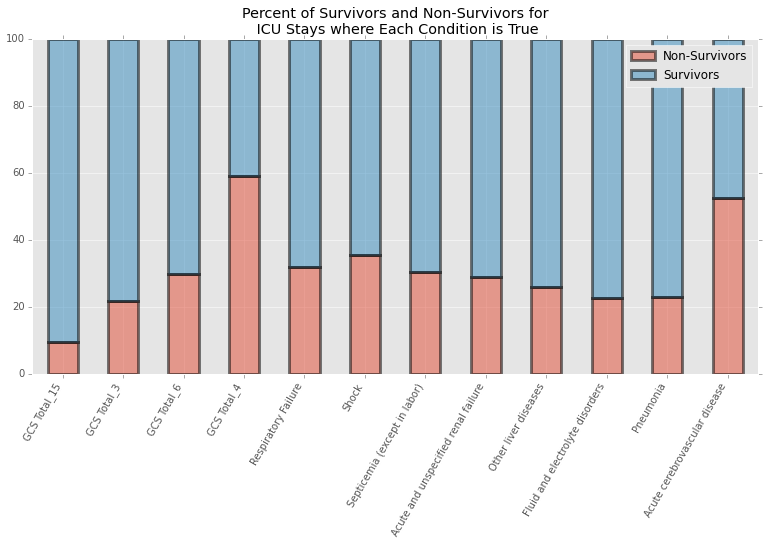

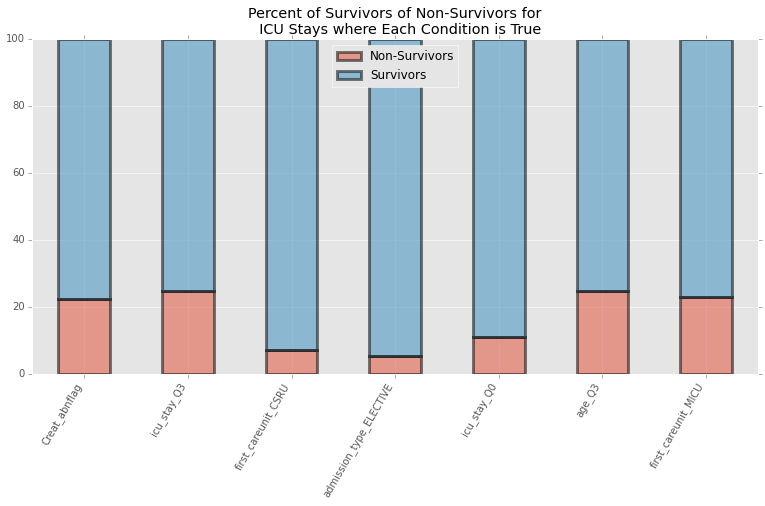

In [7]:
live_dead_dict = {}
col = all_data.columns[1]

for col in all_data.columns[1:]: #all_data.columns[1:]:
    # ALL DATA FOR WHICH 
    positives = all_data[all_data[col] == 1] #all_data[all_data[col] == 1]
    dead = positives.hospital_expire_flag.sum()
    total = positives.hospital_expire_flag.count()
    dead_percent = 100.0*dead/total
    live_percent = 100.0*(total-dead)/total
    live_dead_dict[col] = [dead_percent, live_percent]
    
live_dead_df =pd.DataFrame.from_dict(live_dead_dict)
live_dead_df.index = [['Non-Survivors', 'Survivors']]
#display(live_dead_df[diagnoses_list[1:]])
live_dead_df[diagnoses_list[1:]].transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Percent of Survivors and Non-Survivors for \n ICU Stays where Each Condition is True")
plt.xticks(rotation = 60, ha = 'right')
#display(live_dead_df[meas_list[1:]])
live_dead_df[meas_list[1:]].transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Percent of Survivors of Non-Survivors for  \n  ICU Stays where Each Condition is True")
plt.xticks(rotation = 60, ha = 'right')


'\n#display(live_dead_df[meas_list[1:]])\nlive_dead_df[meas_list[1:]].transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = \'black\', linewidth = 3, \n                                alpha = 0.5, title = "Percent of Survivors of Non-Survivors for  \n  ICU Stays where Each Condition is True")\nplt.xticks(rotation = 60, ha = \'right\')\n'

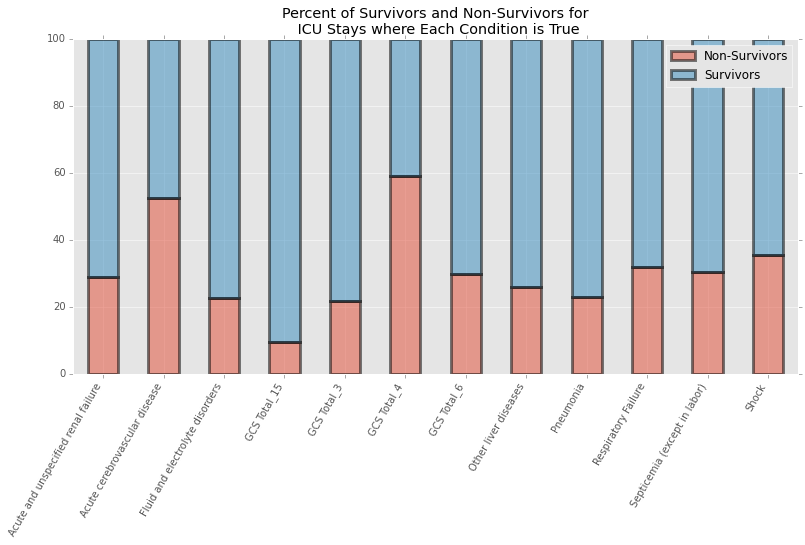

In [8]:
live_dead_dict = {}
col = diagnoses_features.columns[1]

for col in diagnoses_features.columns[1:]: #all_data.columns[1:]:
    # ALL DATA FOR WHICH 
    positives = diagnoses_features[diagnoses_features[col] == 1] #all_data[all_data[col] == 1]
    dead = positives.hospital_expire_flag.sum()
    total = positives.hospital_expire_flag.count()
    dead_percent = 100.0*dead/total
    live_percent = 100.0*(total-dead)/total
    live_dead_dict[col] = [dead_percent, live_percent]
    
live_dead_df =pd.DataFrame.from_dict(live_dead_dict)
live_dead_df.index = [['Non-Survivors', 'Survivors']]
#display(live_dead_df[diagnoses_list[1:]])
live_dead_df.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Percent of Survivors and Non-Survivors for \n ICU Stays where Each Condition is True")
plt.xticks(rotation = 60, ha = 'right')

'''
#display(live_dead_df[meas_list[1:]])
live_dead_df[meas_list[1:]].transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Percent of Survivors of Non-Survivors for  \n  ICU Stays where Each Condition is True")
plt.xticks(rotation = 60, ha = 'right')
'''

In [9]:
(live_dead_df/100).transpose()

,Non-Survivors,Survivors
Acute and unspecified renal failure,0.288608,0.711392
Acute cerebrovascular disease,0.526316,0.473684
Fluid and electrolyte disorders,0.225476,0.774524
GCS Total_15,0.094463,0.905537
GCS Total_3,0.216129,0.783871
GCS Total_4,0.590909,0.409091
GCS Total_6,0.299065,0.700935
Other liver diseases,0.257778,0.742222
Pneumonia,0.229560,0.770440
Respiratory Failure,0.319933,0.680067


## GENERATE GRAPHS ILLUSTRATING THE RATES OF TRUE VALUES IN SURVIVAL AND NON-SURVIVAL GROUPS

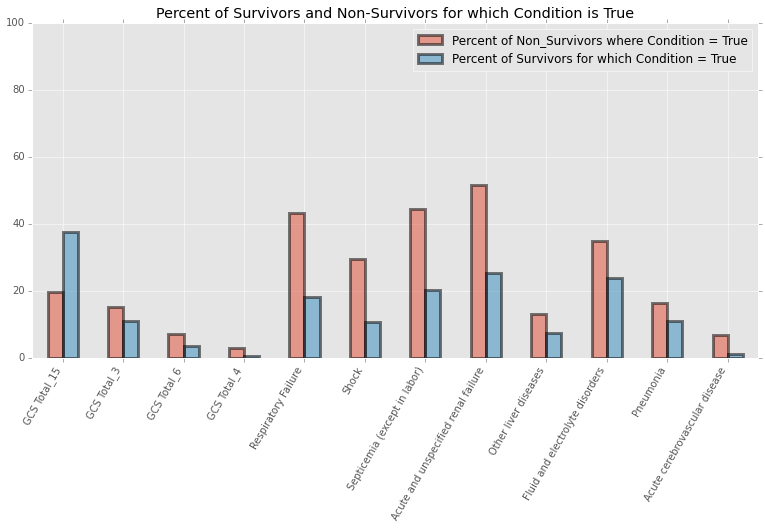

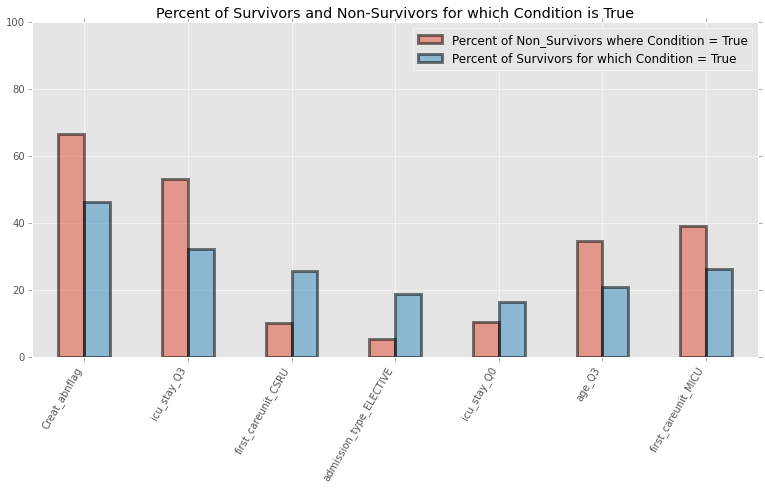

In [10]:
dead_positive_dict = {}
non_survivors = all_data[all_data.hospital_expire_flag == 1]

# CALCULATION OF THE PERCENT OF NON-SURVIVORS FOR WHICH EACH CONDITION IS TRUE AND FALSE
for col in non_survivors.columns[1:]:
    # NUMBER OF NON-SURVIVORS FOR WHICH CONDITION IS TRUE
    dead_positive = non_survivors[col].sum()
    total = non_survivors[col].count()
    # PERCENTAGE OF NON-SURVIVORS FOR WHICH CONDITION IS FALSE AND TRUE
    positive_percent = 100.0*dead_positive/total
    negative_percent = 100.0*(total-dead_positive)/total
    dead_positive_dict[col] = [positive_percent, negative_percent]
    
dead_positive_df =pd.DataFrame.from_dict(dead_positive_dict)
dead_positive_df.index = [['Percent of Non_Survivors where Condition = True', 'Live']]
#display(dead_positive_df)
'''
live_dead_df.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Percent of Non_Survivor Samples with Positive Label")
'''

live_positive_dict = {}
survivors = all_data[all_data.hospital_expire_flag == 0]

# CALCULATION OF THE PERCENT OF SURVIVORS FOR WHICH EACH CONDITION IS TRUE AND FALSE
for col in survivors.columns[1:]:
    # NUMBER OF SURVIVORS FOR WHICH CONDITION IS TRUE
    live_positive = survivors[col].sum()
    total = survivors[col].count()
    # PERCENT OF SURVIVORS FOR WHICH CONDITION IS TRUE AND FALSE
    positive_percent = 100.0*live_positive/total
    negative_percent = 100.0*(total-live_positive)/total
    live_positive_dict[col] = [positive_percent, negative_percent]
    
live_positive_df=pd.DataFrame.from_dict(live_positive_dict)
live_positive_df.index = [['Percent of Survivors for which Condition = True', 'Live2']]
#display(live_positive_df)

positive_df = dead_positive_df.append(live_positive_df)
#display(positive_df[list(diagnoses_features.columns[1:])])
# PLOTTING PERCENTAGES OF SURVIVORS AND NON-SURVIVORS FOR WHCIH CONDITION IS TRUE. 
# PLOTTING DIAGNOSES FEATURES IN ONE PLOT
ax1 = positive_df[diagnoses_list[1:]].transpose()[['Percent of Non_Survivors where Condition = True','Percent of Survivors for which Condition = True']].plot.bar(stacked = False, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Percent of Survivors and Non-Survivors for which Condition is True")
plt.xticks(rotation = 60, ha = 'right')
ax1.set_ylim([0,100]) 
#ax1.legend(loc="upper left", bbox_to_anchor=(0.75,0.6),fontsize=12)
# PLOTTING REST OF FEATURES IN ANOTHER PLOT
ax2 = positive_df[meas_list[1:]].transpose()[['Percent of Non_Survivors where Condition = True','Percent of Survivors for which Condition = True']].plot.bar(stacked = False, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Percent of Survivors and Non-Survivors for which Condition is True")
plt.xticks(rotation = 60, ha = 'right')
ax2.set_ylim([0,100])
plt.show()



# CALCULATE SURVIVAL RATES

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

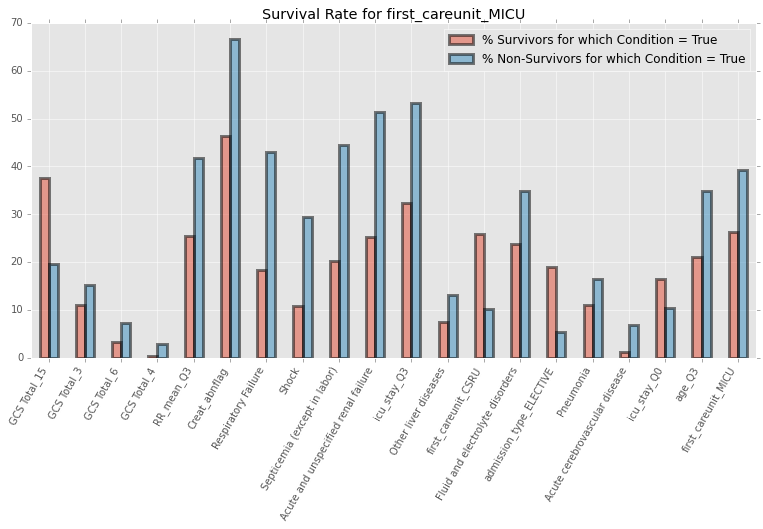

In [11]:

total = all_data.shape[1]



# FOR SURVIVORS AND NON-SURVIVORS, CALCULATING THE PERCENTAGE OF ICU STAYS FOR 
# WHICH EACH CONDITION IS TRUE


deads = all_data[all_data.hospital_expire_flag ==1].sum()
deads.name = "Number of True Values in Non-Survivors"
# COUNT THE NUMBER OF NON-SURVIVORS
all_deads = all_data[all_data.hospital_expire_flag == 1].count()
all_deads.name = "Number of Non-Survivors"

# FOR SURVIVORS, COUNT THE NUMBER OF TRUE VALUES FOR EACH FEATURE
survives = all_data[all_data.hospital_expire_flag == 0].sum()
survives.name = "Number of True Values in Survivors"

# COUNT THE TOTAL NUMBER OF SURVIVORS
all_survives = all_data[all_data.hospital_expire_flag == 0].count()
all_survives.name = "Number of Surivor Patients"

dead_percent = 100.00*(deads / all_deads)
dead_percent.name = "% Non-Survivors for which Condition = True"
live_percent = 100.00*(survives / all_survives)
live_percent.name = "% Survivors for which Condition = True"

mortality_percents = pd.concat([live_percent, dead_percent], axis = 1)

    #display(monkey)

mortality_percents.rename(index=str, columns={"Pneumonia (except that caused by tuberculosis or sexually transmitted disease)": "Pneumonia",
                                         "Respiratory failure; insufficiency; arrest (adult)": "Respiratory Failure"}, 
                     inplace = True)
ax = mortality_percents.iloc[1:].plot.bar(stacked = False, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Survival Rate for " + col)
plt.xticks(rotation = 60, ha = 'right')
#ax.set_ylim([0,100])

## CREATING BENCHMARK FOR ALL CLASSIFIERS

In [12]:
# CREATING BASELINE SCORES USING 20 INPUT FEATURES AND 
# CLASSIFIERS WITH DEFAULT SETTINGS

SVC = svm.SVC()
Kneighb = KNeighborsClassifier()
LSVC = svm.LinearSVC()
MLP = MLPClassifier()
Tree = DecisionTreeClassifier() 

default_clfs = [SVC, Kneighb, LSVC, MLP, Tree]

X_best = all_data[all_data.columns[1:]]
y = all_data['hospital_expire_flag']

X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = 0.20, random_state = 42)

first = True

for clf in default_clfs:        
    clf.fit(X_train, y_train)
    y_true, y_pred = y_test, clf.predict(X_test)
    scores_report = metrics.classification_report(y_true, y_pred)
    #print type(clf).__name__
    #print scores_report
            
        
    # CONVERT SCORES_REPORT TO DATAFRAME
    scores = scores_report.split()
    #display(scores)
    cols = scores[:4]
    #cols = ['default ' + x for x in cols]
   
    ind = ['Survivors', 'Non-Survivors', 'Avg/Total']
    # CLEAN THIS UP
    dat = [[float(x) for x in scores[5:9]], [float(x) for x in scores[10:14]], 
                                            [float(x) for x in scores[17:22]]]
    
    key = type(clf).__name__
    #print key
    arrays = [[key, key, key], ind]
    tuples = list(zip(*arrays))
    mindex = pd.MultiIndex.from_tuples(tuples, names=['Classifier', 'Classes'])
    if first:
        def_scores = pd.DataFrame(dat, columns = cols, index = mindex)
        first = False
    else: 
        def_scores = def_scores.append(pd.DataFrame(dat, columns = cols, index = mindex))
        

def_scores.name = "Default Classifier Scores"
#def_scores.sort_index()
display(def_scores.sort_index())
#def_scores.to_clipboard()

/Users/robertbeetel/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision  recall  f1-score  support
Classifier             Classes                                            
DecisionTreeClassifier Avg/Total           0.81    0.81      0.81    533.0
                       Non-Survivors       0.33    0.33      0.33     75.0
                       Survivors           0.89    0.89      0.89    458.0
KNeighborsClassifier   Avg/Total           0.79    0.83      0.81    533.0
                       Non-Survivors       0.31    0.17      0.22     75.0
                       Survivors           0.87    0.94      0.90    458.0
LinearSVC              Avg/Total           0.82    0.86      0.82    533.0
                       Non-Survivors       0.48    0.13      0.21     75.0
                       Survivors           0.87    0.98      0.92    458.0
MLPClassifier          Avg/Total           0.81    0.84      0.82    533.0
                       Non-Survivors       0.39    0.20      0.27     75.0
                       Survivors           0.88    0.95      0.91    458.0
SVC                    Avg/Total           0.74    0.86      0.79    533.0
                       Non-Survivors       0.00    0.00      0.00     75.0
                       Survivors           0.86    1.00      0.92    458.0

,F1 Metric,Recall Metric
DecisionTreeClassifier,0.66,0.66
KNeighborsClassifier,0.44,0.34
LinearSVC,0.42,0.26
MLPClassifier,0.54,0.40
SVC,0.00,0.00


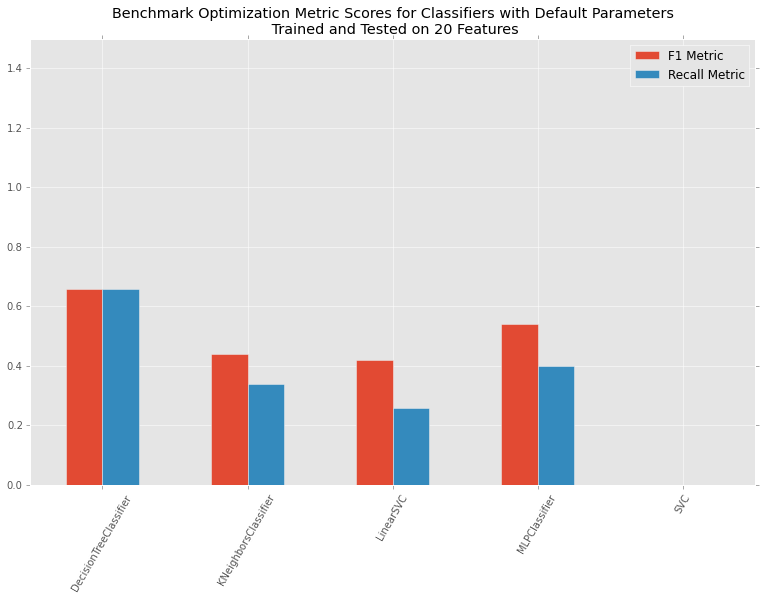

In [14]:
monkey = def_scores.copy()
classers = list(monkey.index.levels[0])
metric_dict = {}

monkey['f1 metric'] = 0.00
monkey['recall metric'] = 0.00

for clfr in classers:
    f1survs = monkey['f1-score'][clfr, 'Survivors']
    f1deads = monkey['f1-score'][clfr, 'Non-Survivors']
    f1met = (f1survs+f1deads)-abs(f1survs-f1deads)
    recall_survs = monkey['recall'][clfr, 'Survivors']
    recall_deads = monkey['recall'][clfr, 'Non-Survivors']
    recallmet = (recall_survs+recall_deads)-abs(recall_survs-recall_deads)
    #display(recallmet)
    metric_dict[clfr] = [f1met, recallmet]
    monkey['f1 metric'][clfr, 'avg/total'] = f1met
    monkey['recall metric'][clfr, 'avg/total'] = recallmet

#display(monkey)
bm_metric_df = pd.DataFrame.from_dict(metric_dict)
bm_metric_df.index = ['F1 Metric', 'Recall Metric']
bm_metric_df = bm_metric_df.transpose()
display(bm_metric_df)





#ax1 = bl_metric_df['F1 Metric'].plot.bar(legend = True, figsize = (13,8), rot = 60)
#ax2 = bl_metric_df['Recall Metric'].plot.bar(secondary_y=True, label = 'Recall Metric', legend = True, 
#                                         rot = 60)
ax1 = bm_metric_df.plot.bar(legend = True, figsize = (13,8), rot = 60)
ax1.set_ylim(0,1.5)
#ax2.set_ylim(0,1.5)

plt.title('Benchmark Optimization Metric Scores for Classifiers with Default Parameters\n Trained and Tested on 20 Features')

#plt.xticks(rotation = 60, ha = 'right')


## XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
## TRAINING THE SVC TAKES A VERY LONG TIME, ON THE ORDER OF HOURS THE OPTIMIZED PARAMETERS, ALONG WITH THOSE OF ADDITIONAL CLASSIFIERS HAVE BEEN PREVIOUSLY CALCULATED AND SAVED. BELOW IS CODE TO CALCULATE THESE VALUES. THESE VALUES HAVE BEEN PREVIOUSLY CALCULATED AND SAVED TO FILE. THIS CAN BE SKIPPED AND FURTHER DOWN IS CODE TO READ IN THOSE VALUE FROM FILE
## XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
## OPTIMIZING SVC CLASSIFIER OVER PARAMETER AND FEATURE SPACE

In [15]:
# THE SUPPORT VECTOR CLASSIFIER IS OPTIMZED TO TO F1-SCORE AND RECALL OVER THE GIVEN PARAMETER SPACE
# AND OVER THE NUMBER OF FEATURES USING THE TOP 20 FEATURES RANKED ACCORDING TO CHI2 SCORE
# RECALL FOR MORTALITY PREDICTION IS IMPORTANT IN THAT WE DON'T WANT FALSE NEGATIVES. 
# THE SUPPORT VECTOR CLASSIFIER TAKES A VERY LONG TIME TO OPTIMIZE OVER THE GIVEN PARAMETER SPACE SO 
# THAT IS BEING DONE INDIVIDUALLY HERE. THE REMAINING CLASSIFIERS ARE OPTIMIZED BELOW

optimized_clfs = {}

In [ ]:
#LinearSVC CLASSIFIER PARAMETERES
SVC_params = {'C':[0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9,1],  
               'class_weight': [{1:3, 0:1}, {1:4, 0:1}, {1:5, 0:1}],
               'kernel': ['rbf', 'sigmoid', 'poly',], 
               'degree': [2,3,4], 
               'decision_function_shape': ['ovr','ovo']
                                
              }


# CLASSIFIER SCORES
scores = ['f1', 'recall'] #'accuracy', , 'precision']

# DICTIONARY OF CLASSIFIERS AND CORRESPONDING PARAMETERS 
SVC = svm.SVC(random_state = 42)
SVC_stuff = [SVC, SVC_params]

classifiers = {
               'SVC' : SVC_stuff
              }
               


for key in classifiers.keys():
    
    recall_mortality = -100
    f1_mortality = -100
    optimized_params = {}
    optimized = {}
    optimized_scores = ""
    recall_scores = {}
    f1_scores = {}

    print "Evaluating {}".format(key)
    for num_feats in range(8, all_data.shape[1]):
        print "{} features".format(num_feats)
        # FEATURES AND TARGETS
        X_best = all_data[all_data.columns[1:num_feats]]
        y = all_data['hospital_expire_flag']

        X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = 0.30, random_state = 42)
        
        
        # MAY NOT BE NECESSARY THE WAY THE CODE IS CURRENTLY BROKEN OUT
        for score in scores:
            #print"# Optimizing parameters for {} classifier to {} score using {} features".format(key, score, num_feats)

         
            clf = GridSearchCV(classifiers[key][0], classifiers[key][1], cv = 5, 
                           scoring = score)

            clf.fit(X_train, y_train)
    
            y_true, y_pred = y_test, clf.predict(X_test)
            scores_report = metrics.classification_report(y_true, y_pred)
            
            
            #print(clf.best_params_)
            #print(scores_report)
         
            if score == 'recall':
                surv, mort = metrics.recall_score(y_true, y_pred, average = None)
                # a metric that maximizes both variables and minimizes the difference between them
                recall_metric = mort + surv - (abs(mort-surv))
                recall_scores[str(num_feats)] = [surv, mort, recall_metric]
                if (recall_metric > recall_mortality):
                    recall_mortality = recall_metric #math.sqrt(mort**2 + surv**2)
                    optimized = clf.best_params_
                    optimized['features'] = num_feats
                    optimized_scores = scores_report
                    recall_str = key + '_recall'
                    if recall_str not in optimized_clfs:
                        optimized_clfs[recall_str] = {}
                    optimized_clfs[recall_str]['CLF'] = clf.best_estimator_
                    optimized_clfs[recall_str]['PARAMS'] = optimized
                    optimized_clfs[recall_str]['SCORES'] = optimized_scores
                   
         
            elif score == 'f1':
            
                surv_f1, mort_f1 = metrics.f1_score(y_true, y_pred, average = None)
                #a metric that maximizes both variables and minimizes the difference between them
                f1_metric = surv_f1 + mort_f1 - (abs(surv_f1-mort_f1))
                f1_scores[str(num_feats)] = [surv_f1, mort_f1, f1_metric]
                if (f1_metric > f1_mortality):
                    f1_mortality = f1_metric #math.sqrt(mort**2 + surv**2)
                    #recall_delta = abs(mort-surv)
                    f1_optimized = clf.best_params_
                    f1_optimized['features'] = num_feats
                    f1_optimized_scores = scores_report
                    f1_str = key + '_f1'
                    if f1_str not in optimized_clfs.keys():
                        optimized_clfs[f1_str] = {}
                    optimized_clfs[f1_str]['CLF'] = clf.best_estimator_
                    optimized_clfs[f1_str]['PARAMS'] = f1_optimized
                    optimized_clfs[f1_str]['SCORES'] = f1_optimized_scores
                    

    print "ANALYSIS COMPLETE"
    recalls = pd.DataFrame.from_dict(recall_scores)
    recalls = recalls.transpose()
    recalls['features'] = recalls.index
    recalls['features'] = recalls['features'].apply(lambda x: int(x))
    recalls.sort_values(by = 'features', inplace = True)
    recalls.columns = ['Survivors', 'Non-Survivors', 'Metric', 'Features']
    recalls[['Survivors', 'Non-Survivors', 'Metric']].plot(title = 'Recall Scores', 
                                                           use_index = True, figsize = (16,6))
    plt.show()
    print "Optimized Parameters for the {} Classifier for recall are".format(key)
    print(optimized)
    print "optimized Scores are"
    print(optimized_scores)
       
    
    f1s = pd.DataFrame.from_dict(f1_scores)
    f1s = f1s.transpose()
    f1s['features'] = f1s.index
    f1s['features'] = f1s['features'].apply(lambda x: int(x))
    f1s.sort_values(by = 'features', inplace = True)
    f1s.columns = ['Survivors', 'Non-Survivors', 'Metric', 'Features']
    f1s[['Survivors', 'Non-Survivors', 'Metric']].plot(title = 'F1 Scores', use_index = True, figsize = (16,6))
    plt.show()
    print "Optimized Parameters for the {} Classifier for f1_score are".format(key)
    print(f1_optimized)
    print "Optimized Scores are"
    print(f1_optimized_scores)
    

## OPTIMIZING CLASSIFIERS OVER PARAMETER SPACE AND FEATURE SET SIZES

Evaluating MLP
8 features
MLP Layers (8, 4.0)


/Users/robertbeetel/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/robertbeetel/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


9 features
MLP Layers (9, 4.0)
10 features
MLP Layers (10, 5.0)
11 features
MLP Layers (11, 5.0)
12 features
MLP Layers (12, 6.0)
13 features
MLP Layers (13, 6.0)
14 features
MLP Layers (14, 7.0)
15 features
MLP Layers (15, 7.0)
16 features
MLP Layers (16, 8.0)
17 features
MLP Layers (17, 8.0)
18 features
MLP Layers (18, 9.0)
19 features
MLP Layers (19, 9.0)
20 features
MLP Layers (20, 10.0)
ANALYSIS COMPLETE


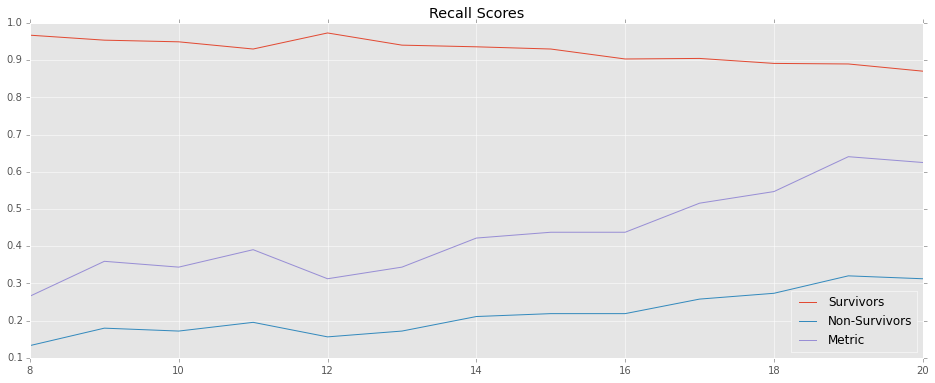

Optimized Parameters for recall are
{'activation': 'relu', 'features': 19, 'solver': 'lbfgs'}
optimized Scores are
             precision    recall  f1-score   support

          0       0.87      0.89      0.88       672
          1       0.36      0.32      0.34       128

avg / total       0.79      0.80      0.79       800



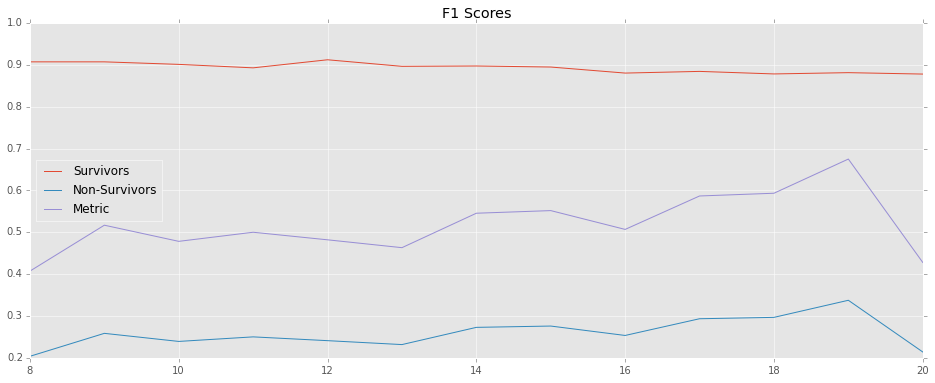

Optimized Parameters for f1 are
{'activation': 'relu', 'features': 19, 'solver': 'lbfgs'}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.87      0.89      0.88       672
          1       0.36      0.32      0.34       128

avg / total       0.79      0.80      0.79       800

Evaluating Tree
8 features
9 features
10 features
11 features
12 features
13 features
14 features
15 features
16 features
17 features
18 features
19 features
20 features
ANALYSIS COMPLETE


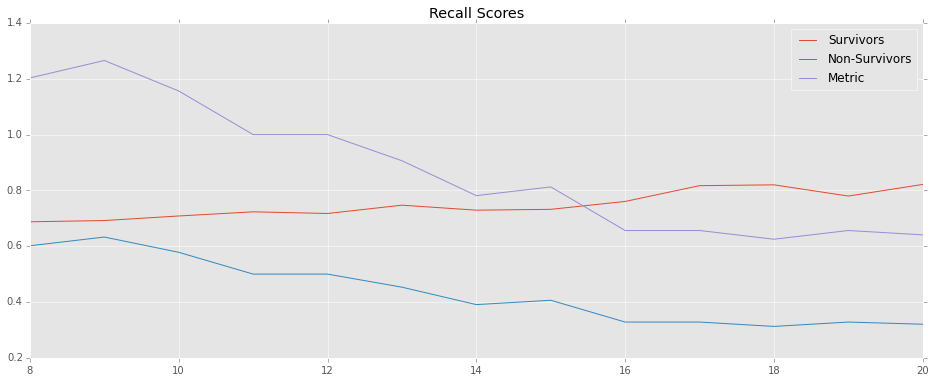

Optimized Parameters for recall are
{'criterion': 'gini', 'features': 9, 'class_weight': {0: 1, 1: 6}}
optimized Scores are
             precision    recall  f1-score   support

          0       0.91      0.69      0.79       672
          1       0.28      0.63      0.39       128

avg / total       0.81      0.68      0.72       800



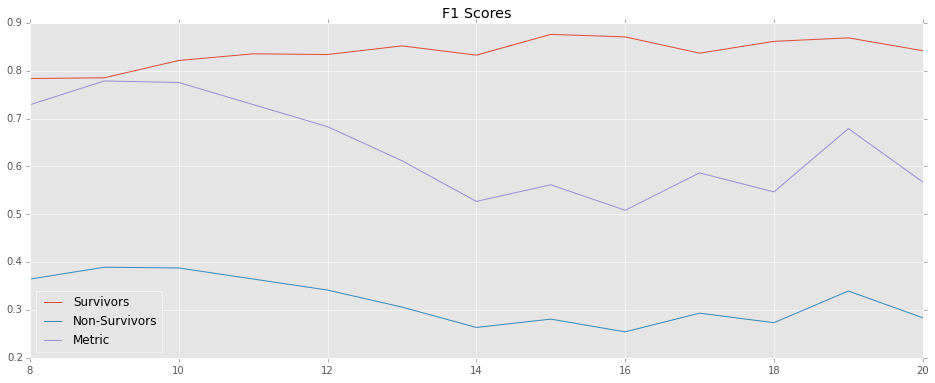

Optimized Parameters for f1 are
{'criterion': 'entropy', 'features': 9, 'class_weight': {0: 1, 1: 5.5}}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.91      0.69      0.79       672
          1       0.28      0.63      0.39       128

avg / total       0.81      0.68      0.72       800

Evaluating Kneighbors
8 features
9 features
10 features
11 features
12 features
13 features
14 features
15 features
16 features
17 features
18 features
19 features
20 features
ANALYSIS COMPLETE


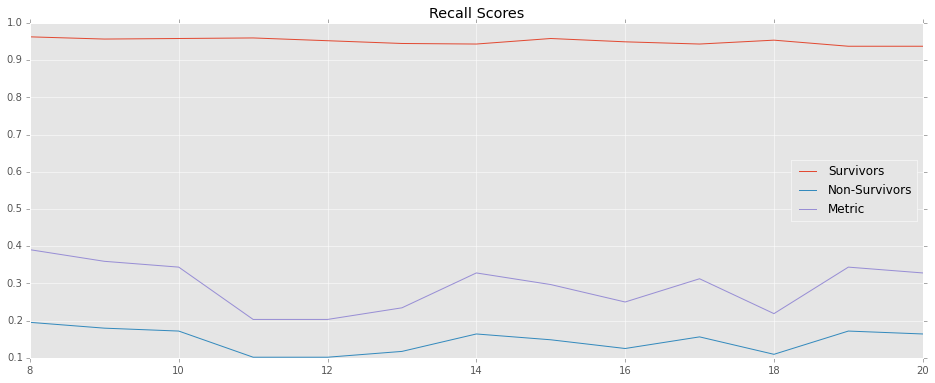

Optimized Parameters for recall are
{'n_neighbors': 10, 'weights': 'distance', 'features': 8, 'algorithm': 'auto'}
optimized Scores are
             precision    recall  f1-score   support

          0       0.86      0.96      0.91       672
          1       0.50      0.20      0.28       128

avg / total       0.80      0.84      0.81       800



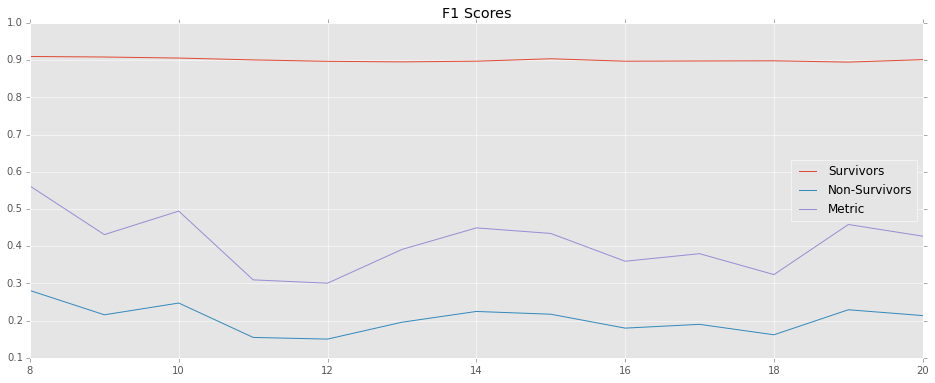

Optimized Parameters for f1 are
{'n_neighbors': 10, 'weights': 'distance', 'features': 8, 'algorithm': 'auto'}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.86      0.96      0.91       672
          1       0.50      0.20      0.28       128

avg / total       0.80      0.84      0.81       800

Evaluating LSVC
8 features
9 features
10 features
11 features
12 features
13 features
14 features
15 features
16 features
17 features
18 features
19 features
20 features
ANALYSIS COMPLETE


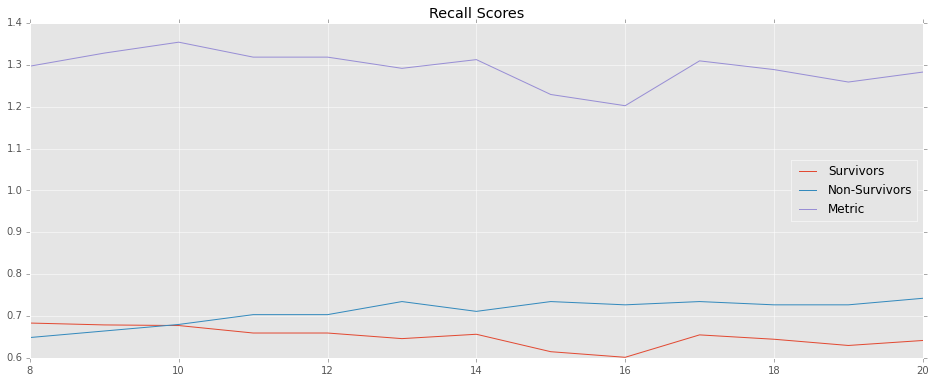

Optimized Parameters for recall are
{'loss': 'squared_hinge', 'C': 0.1, 'features': 10, 'class_weight': {0: 1, 1: 6}}
optimized Scores are
             precision    recall  f1-score   support

          0       0.92      0.68      0.78       672
          1       0.29      0.68      0.40       128

avg / total       0.82      0.68      0.72       800



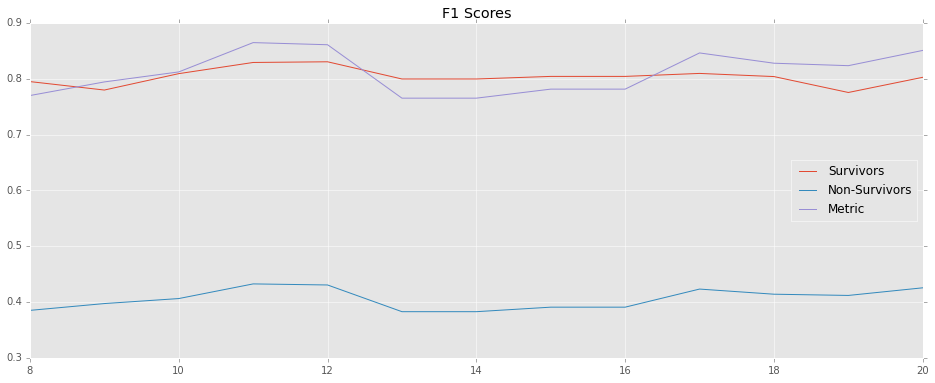

Optimized Parameters for f1 are
{'loss': 'squared_hinge', 'C': 0.4, 'features': 11, 'class_weight': {0: 1, 1: 4.5}}
Optimized Scores are
             precision    recall  f1-score   support

          0       0.91      0.76      0.83       672
          1       0.33      0.62      0.43       128

avg / total       0.82      0.74      0.77       800

ANALYSIS COMPLETE


In [16]:
# OPTIMIZING THE KNEIGHBORS, LINEAR SUPPORT VECTOR AND MULTI LAYER PERCEPTRON CLASSIFIERS TO F1-SCORE AND RECALL
# OVER THE GIVEN PARAMETER SPACE AND OVER THE NUMBER OF FEATURES USING THE TOP 20 FEATURES RANKED 
# ACCORDING TO CHI2 SCORE
# RECALL FOR MORTALITY PREDICTION IS IMPORTANT IN THAT WE DON'T WANT FALSE NEGATIVES. 

# NEAREST NEIGHBOR CLASSIFIER PARAMETERS

kneighbors_params = {'n_neighbors': [2,4,6,8,10,12], 
                     'weights': ['uniform', 'distance'], 
                     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    }
#LinearSVC CLASSIFIER PARAMETERES
LSVC_params = {'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9,1],  
               'class_weight': [#{1:1, 0:1}, {1:2, 0:1}, {1:2.5, 0:1}, 
                                {1:3, 0:1}, {1:3.5, 0:1}, {1:4, 0:1}, 
                                {1:4.5, 0:1}, {1:5, 0:1}, {1:5.5, 0:1}, {1:6, 0:1}], 
                                #{1:6, 0:1}, {1:6.7, 0:1}, {1:7, 0:1}],
                   'loss':['hinge', 'squared_hinge']
              }


MLP_params = {
              'activation': ['identity', 'logistic', 'tanh', 'relu'], 
              'solver': ['lbfgs', 'sgd', 'adam']
             
             }

Tree_params = {
               'class_weight': [{1:1, 0:1}, {1:2, 0:1}, {1:2.5, 0:1}, 
                                {1:3, 0:1}, {1:3.5, 0:1}, {1:4, 0:1}, 
                                {1:4.5, 0:1}, {1:5, 0:1}, {1:5.5, 0:1}, {1:6, 0:1}],
                'criterion': ['gini', 'entropy']
              }



# DICTIONARY OF CLASSIFIERS AND CORRESPONDING PARAMETERS 


# CLASSIFIER SCORES
scores = ['f1', 'recall'] #'accuracy',, 'recall' , 'precision']

# DICTIONARY OF CLASSIFIERS AND CORRESPONDING PARAMETERS 
Kneighb = KNeighborsClassifier()
LSVC = svm.LinearSVC(random_state = 42)
MLP = MLPClassifier(random_state = 42)
Tree = DecisionTreeClassifier(random_state = 42) 
#SVC = svm.SVC(random_state = 42)
LSVC_stuff = [LSVC, LSVC_params]
KNeighbors_stuff = [Kneighb, kneighbors_params]
MLP_stuff = [MLP, MLP_params]
Tree_stuff = [Tree, Tree_params]

#SVC_stuff = [SVC, SVC_params]
classifiers = {'LSVC': LSVC_stuff,
               'Kneighbors': KNeighbors_stuff, 
               'MLP': MLP_stuff,
               'Tree': Tree_stuff
               
              }
                


for key in classifiers.keys():
    
    recall_mortality = -100000
    f1_mortality = -100000
    optimized_params = {}
    optimized = {}
    
    optimized_scores = ""
    recall_scores = {}
    f1_scores = {}

    print "Evaluating {}".format(key)
    for num_feats in range(8, all_data.shape[1]):
        print "{} features".format(num_feats)
        # FEATURES AND TARGETS
        X_best = all_data[all_data.columns[1:(num_feats+1)]]
        y = all_data['hospital_expire_flag']

        X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = 0.30, random_state = 42)
        
        if key == 'MLP':
            input_layer = num_feats
            middle_layer = int(math.ceil(num_feats/2))
            classifiers[key][0] = MLPClassifier(random_state = 42, 
                                                hidden_layer_sizes = (input_layer, middle_layer)
                                                )
            print "MLP Layers ({}, {})".format(num_feats, math.ceil(num_feats/2))
        # MAY NOT BE NECESSARY THE WAY THE CODE IS CURRENTLY BROKEN OUT
        for score in scores:
            #print"# Optimizing parameters for {} classifier to {} score using {} features".format(key, score, num_feats)

         
            clf = GridSearchCV(classifiers[key][0], classifiers[key][1], cv = 5, 
                           scoring = score)

            clf.fit(X_train, y_train)
    
            y_true, y_pred = y_test, clf.predict(X_test)
            scores_report = metrics.classification_report(y_true, y_pred)
            #print(scores_report)
         
            if score == 'recall':
                surv, mort = metrics.recall_score(y_true, y_pred, average = None)
                # a metric that maximizes both variables and minimizes the difference between them
                recall_metric = mort + surv - (abs(mort-surv))
                recall_scores[str(num_feats)] = [surv, mort, recall_metric]
                if (recall_metric > recall_mortality):
                    recall_mortality = recall_metric 
                    optimized = clf.best_params_
                    optimized['features'] = num_feats
                    optimized_scores = scores_report
                    recall_str = key + '_recall'
                    if recall_str not in optimized_clfs:
                        optimized_clfs[recall_str] = {}
                    optimized_clfs[recall_str]['CLF'] = clf.best_estimator_
                    optimized_clfs[recall_str]['PARAMS'] = optimized
                    optimized_clfs[recall_str]['SCORES'] = optimized_scores
                    #print "OPTIMIZED RECALL VALUES REGISTERED"
                    
         
            elif score == 'f1':
            
                surv_f1, mort_f1 = metrics.f1_score(y_true, y_pred, average = None)
                #a metric that maximizes both variables and minimizes the difference between them
                f1_metric = surv_f1 + mort_f1 - (abs(surv_f1-mort_f1))
                f1_scores[str(num_feats)] = [surv_f1, mort_f1, f1_metric]
                if (f1_metric > f1_mortality):
                    f1_mortality = f1_metric #math.sqrt(mort**2 + surv**2)
                    #recall_delta = abs(mort-surv)
                    f1_optimized = clf.best_params_
                    f1_optimized['features'] = num_feats
                    f1_optimized_scores = scores_report
                    f1_str = key + '_f1'
                    if f1_str not in optimized_clfs:
                        optimized_clfs[f1_str] = {}
                    optimized_clfs[f1_str]['CLF'] = clf.best_estimator_
                    optimized_clfs[f1_str]['PARAMS'] = f1_optimized
                    optimized_clfs[f1_str]['SCORES'] = f1_optimized_scores
                    #print "OPTIMIZED F1 VALUES REGISTERED"
                    
            
   
    print "ANALYSIS COMPLETE"
    recalls = pd.DataFrame.from_dict(recall_scores)
    recalls = recalls.transpose()
    recalls['features'] = recalls.index
    recalls['features'] = recalls['features'].apply(lambda x: float(x))
    recalls.sort_values(by = 'features', inplace = True)
    recalls.columns = ['Survivors', 'Non-Survivors', 'Metric', 'Features']
    recalls[['Survivors', 'Non-Survivors', 'Metric']].plot(title = 'Recall Scores', 
                                                           use_index = True, figsize = (16,6))
    plt.show()
    print "Optimized Parameters for recall are"
    print(optimized)
    print "optimized Scores are"
    print(optimized_scores)
        
    
    f1s = pd.DataFrame.from_dict(f1_scores)
    f1s = f1s.transpose()
    f1s['features'] = f1s.index
    f1s['features'] = f1s['features'].apply(lambda x: float(x))
    f1s.sort_values(by = 'features', inplace = True)
    f1s.columns = ['Survivors', 'Non-Survivors', 'Metric', 'Features']
    f1s[['Survivors', 'Non-Survivors', 'Metric']].plot(title = 'F1 Scores', use_index = True, figsize = (16,6))
    plt.show()
    print "Optimized Parameters for f1 are"
    print(f1_optimized)
    print "Optimized Scores are"
    print(f1_optimized_scores)
    
print "ANALYSIS COMPLETE"

## CLASSIFIERS WITH OPTIMIZED PARAMETERS OVER VARIOUS TRAIN-TEST-SPLIT SIZES

In [ ]:
print "monkey"

In [ ]:
# TRAINING AND TESTING CLASSIFIERS PREVIOUSLY OPTIMIZED OVER PARAMETER SPACE AND FEATURES 
# OVER A RANGE OF TRAIN TEST SPLIT SIZE. 

for key in optimized_clfs.keys():
    
    recall_mortality = 0
    f1_mortality = 0
    optimized_params = {}
    optimized = {}
    optimized_scores = ""
    recall_scores = {}
    f1_scores = {}

    print "Evaluating {}".format(key)
    for testes_size in np.linspace(0.1, 0.5, 9):
        # DEFINING MLP HERE SO THAT WE CAN ALTER THE NUMBER OF INPUT HIDDEN NODES TO MATCH FEATURES
        
        #print "{} test size".format(testes_size)
        # FEATURES AND TARGETS
        features = optimized_clfs[key]['PARAMS']['features']
        clf = optimized_clfs[key]['CLF']
        X_best = all_data[all_data.columns[1:features]]
        y = all_data['hospital_expire_flag']

        X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = testes_size, random_state = 42)
        
        
        
        clf.fit(X_train, y_train)
    
        y_true, y_pred = y_test, clf.predict(X_test)
        scores_report = metrics.classification_report(y_true, y_pred)
            #print(scores_report)
         
        if 'recall' in key:
            surv, mort = metrics.recall_score(y_true, y_pred, average = None)
                # a metric that maximizes both variables and minimizes the difference between them
            recall_metric = mort + surv - (abs(mort-surv))
            recall_scores[str(testes_size)] = [surv, mort, recall_metric]
            if (recall_metric > recall_mortality):
                recall_mortality = recall_metric #math.sqrt(mort**2 + surv**2)
                optimized = optimized_clfs[key]['PARAMS']
                optimized['test_size'] = testes_size
                optimized_clfs[key]['PARAMS']['test_size'] = testes_size
                optimized_clfs[key]['SCORES'] = scores_report
                optimized_scores = scores_report
                
         
        elif 'f1' in key:
                
            surv_f1, mort_f1 = metrics.f1_score(y_true, y_pred, average = None)
                #a metric that maximizes both variables and minimizes the difference between them
            f1_metric = surv_f1 + mort_f1 - (abs(surv_f1-mort_f1))
            f1_scores[str(testes_size)] = [surv_f1, mort_f1, f1_metric]
            if (f1_metric > f1_mortality):
                f1_mortality = f1_metric #math.sqrt(mort**2 + surv**2)
                #recall_delta = abs(mort-surv)
                f1_optimized = optimized_clfs[key]['PARAMS']
                f1_optimized['test_size'] = testes_size
                optimized_clfs[key]['PARAMS']['test_size'] = testes_size
                optimized_clfs[key]['SCORES'] = scores_report
                f1_optimized_scores = scores_report
                
            
    if 'recall' in key:   
        print "ANALYSIS COMPLETE"
        recalls = pd.DataFrame.from_dict(recall_scores)
        recalls = recalls.transpose()
        recalls['test_size'] = recalls.index
        recalls['test_size'] = recalls['test_size'].apply(lambda x: float(x))
        recalls.sort_values(by = 'test_size', inplace = True)
        recalls.columns = ['Survivors', 'Non-Survivors', 'Metric', 'test_size']
        recalls[['Survivors', 'Non-Survivors', 'Metric']].plot(title = key + ': Recall Scores', 
                                                           use_index = True, figsize = (16,6))
        plt.show()
        print "Optimized Parameters for {} recall-score are".format(key)
        print(optimized)
        print "optimized Scores are"
        print(optimized_scores)
    
    
    elif 'f1' in key:
        f1s = pd.DataFrame.from_dict(f1_scores)
        f1s = f1s.transpose()
        f1s['test_size'] = f1s.index
        f1s['test_size'] = f1s['test_size'].apply(lambda x: float(x))
        f1s.sort_values(by = 'test_size', inplace = True)
        f1s.columns = ['Survivors', 'Non-Survivors', 'Metric', 'test_Size']
        f1s[['Survivors', 'Non-Survivors', 'Metric']].plot(title = key + ': F1 Scores', use_index = True, figsize = (16,6))
        plt.show()
        print "Optimized Parameters for {} f1-score are".format(key)
        print(f1_optimized)
        print "Optimized Scores are"
        print(f1_optimized_scores)
    
print "OPTIMIZATION COMPLETE"

## WRITING OPTIMIZED PARAMETERS FOR ALL CLASSIFIERS TO FILE

In [ ]:
'''
with open('Optimized_Classifiers.txt', 'w') as file:
    file.write(pickle.dumps(optimized_clfs))
'''

## XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
## READING IN PREVIOUSLY CALCULATED OPTIMIZED PARAMETERS. UNCOMMENT OUT CODE AND RUN TO READ IN OPTIMIZED CLASSIFIERS, PARAMETERS AND SCORES
## XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [17]:
# READ IN PREVIOUSLY CALCULATED OPTIMIZED PARAMETERS
optimized_clfs = pickle.load(open('Optimized_Classifiers.txt', 'rb'))

## CREATE DATAFRAME FROM SCORE REPORTS FOR OPTIMIZED CLASSIFERS

In [18]:
# CREATE DATAFRAME FROM SCORE REPORTS FOR OPTIMIZED CLASSIFIERS

first = True
for key in optimized_clfs.keys():
    print(key)
    #print(optimized_clfs[key]['SCORES'])

    # CONVERT SCORES_REPORT TO DATAFRAME
    scores = optimized_clfs[key]['SCORES'].split()
    #display(scores)
    cols = scores[:4]
    '''
    ind = [x for x in scores if scores.index(x) in [4,9,14, 15, 16]]
    ind[2] = ind[2] + ind[3] + ind[4] 
    ind.pop()
    ind.pop()
    '''
    ind = ['Survivors', 'Non-Survivors', 'Avg/Total']
    
    # CLEAN THIS UP
    dat = [[float(x) for x in scores[5:9]], [float(x) for x in scores[10:14]], 
                                            [float(x) for x in scores[17:22]]]
    #display(cols)
    #display(ind)
    #display(dat)
    
    arrays = [[key, key, key], ind]
    tuples = list(zip(*arrays))
    mindex = pd.MultiIndex.from_tuples(tuples, names=['Classifier', 'Classes'])
    if first:
        scores_frame = pd.DataFrame(dat, columns = cols, index = mindex)
        first = False
    else: 
        scores_frame = scores_frame.append(pd.DataFrame(dat, columns = cols, index = mindex))

scores_frame.sort_index(level = 0)


MLP_f1
LSVC_recall
Tree_recall
Tree_f1
Kneighbors_f1
SVC_recall
Kneighbors_recall
MLP_recall
SVC_f1
LSVC_f1


precision  recall  f1-score  support
Classifier        Classes                                            
Kneighbors_f1     Avg/Total           0.80    0.83      0.80   1066.0
                  Non-Survivors       0.47    0.20      0.28    173.0
                  Survivors           0.86    0.96      0.91    893.0
Kneighbors_recall Avg/Total           0.80    0.83      0.80   1066.0
                  Non-Survivors       0.47    0.20      0.28    173.0
                  Survivors           0.86    0.96      0.91    893.0
LSVC_f1           Avg/Total           0.81    0.73      0.76    267.0
                  Non-Survivors       0.33    0.59      0.42     44.0
                  Survivors           0.90    0.76      0.83    223.0
LSVC_recall       Avg/Total           0.81    0.68      0.72   1333.0
                  Non-Survivors       0.30    0.67      0.42    225.0
                  Survivors           0.91    0.68      0.78   1108.0
MLP_f1            Avg/Total           0.78    0.81      0.80    933.0
                  Non-Survivors       0.35    0.24      0.29    147.0
                  Survivors           0.87    0.91      0.89    786.0
MLP_recall        Avg/Total           0.76    0.78      0.77   1200.0
                  Non-Survivors       0.31    0.25      0.28    204.0
                  Survivors           0.85    0.88      0.87    996.0
SVC_f1            Avg/Total           0.81    0.76      0.78    267.0
                  Non-Survivors       0.35    0.57      0.43     44.0
                  Survivors           0.90    0.79      0.84    223.0
SVC_recall        Avg/Total           0.82    0.68      0.72    933.0
                  Non-Survivors       0.28    0.69      0.40    147.0
                  Survivors           0.92    0.68      0.78    786.0
Tree_f1           Avg/Total           0.80    0.69      0.72   1333.0
                  Non-Survivors       0.29    0.60      0.40    225.0
                  Survivors           0.90    0.71      0.79   1108.0
Tree_recall       Avg/Total           0.80    0.69      0.72   1333.0
                  Non-Survivors       0.29    0.60      0.40    225.0
                  Survivors           0.90    0.71      0.79   1108.0

In [ ]:
# WRITING OPTIMIZED SCORES TO FILE
scores_frame.to_csv('Optimized_Classifier_Scores.csv')

In [19]:
display(scores_frame.iloc[scores_frame.index.get_level_values('Classes') == 'Avg/Total'])
display(scores_frame.iloc[scores_frame.index.get_level_values('Classes') == 'Survivors'])
display(scores_frame.iloc[scores_frame.index.get_level_values('Classes') == 'Non-Survivors'])

,,precision,recall,f1-score,support
Classifier,Classes,,,,
MLP_f1,Avg/Total,0.78,0.81,0.80,933.0
LSVC_recall,Avg/Total,0.81,0.68,0.72,1333.0
Tree_recall,Avg/Total,0.80,0.69,0.72,1333.0
Tree_f1,Avg/Total,0.80,0.69,0.72,1333.0
Kneighbors_f1,Avg/Total,0.80,0.83,0.80,1066.0
SVC_recall,Avg/Total,0.82,0.68,0.72,933.0
Kneighbors_recall,Avg/Total,0.80,0.83,0.80,1066.0
MLP_recall,Avg/Total,0.76,0.78,0.77,1200.0
SVC_f1,Avg/Total,0.81,0.76,0.78,267.0


,,precision,recall,f1-score,support
Classifier,Classes,,,,
MLP_f1,Survivors,0.87,0.91,0.89,786.0
LSVC_recall,Survivors,0.91,0.68,0.78,1108.0
Tree_recall,Survivors,0.90,0.71,0.79,1108.0
Tree_f1,Survivors,0.90,0.71,0.79,1108.0
Kneighbors_f1,Survivors,0.86,0.96,0.91,893.0
SVC_recall,Survivors,0.92,0.68,0.78,786.0
Kneighbors_recall,Survivors,0.86,0.96,0.91,893.0
MLP_recall,Survivors,0.85,0.88,0.87,996.0
SVC_f1,Survivors,0.90,0.79,0.84,223.0


,,precision,recall,f1-score,support
Classifier,Classes,,,,
MLP_f1,Non-Survivors,0.35,0.24,0.29,147.0
LSVC_recall,Non-Survivors,0.30,0.67,0.42,225.0
Tree_recall,Non-Survivors,0.29,0.60,0.40,225.0
Tree_f1,Non-Survivors,0.29,0.60,0.40,225.0
Kneighbors_f1,Non-Survivors,0.47,0.20,0.28,173.0
SVC_recall,Non-Survivors,0.28,0.69,0.40,147.0
Kneighbors_recall,Non-Survivors,0.47,0.20,0.28,173.0
MLP_recall,Non-Survivors,0.31,0.25,0.28,204.0
SVC_f1,Non-Survivors,0.35,0.57,0.43,44.0


,F1 Metric,Recall Metric
Kneighbors_f1,0.56,0.40
Kneighbors_recall,0.56,0.40
LSVC_f1,0.84,1.18
LSVC_recall,0.84,1.34
MLP_f1,0.58,0.48
MLP_recall,0.56,0.50
SVC_f1,0.86,1.14
SVC_recall,0.80,1.36
Tree_f1,0.80,1.20
Tree_recall,0.80,1.20


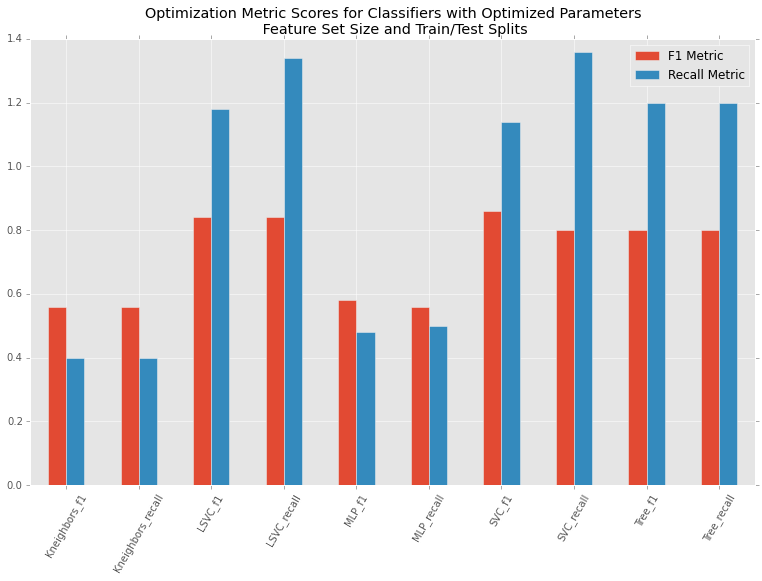

In [20]:
monkey = scores_frame.copy()
classers = list(monkey.index.levels[0])
metric_dict = {}

monkey['f1 metric'] = 0.00
monkey['recall metric'] = 0.00

for clfr in classers:
    f1survs = monkey['f1-score'][clfr, 'Survivors']
    f1deads = monkey['f1-score'][clfr, 'Non-Survivors']
    f1met = (f1survs+f1deads)-abs(f1survs-f1deads)
    recall_survs = monkey['recall'][clfr, 'Survivors']
    recall_deads = monkey['recall'][clfr, 'Non-Survivors']
    recallmet = (recall_survs+recall_deads)-abs(recall_survs-recall_deads)
    #display(recallmet)
    metric_dict[clfr] = [f1met, recallmet]
    monkey['f1 metric'][clfr, 'avg/total'] = f1met
    monkey['recall metric'][clfr, 'avg/total'] = recallmet

#display(monkey)
metric_df = pd.DataFrame.from_dict(metric_dict)
metric_df.index = ['F1 Metric', 'Recall Metric']
metric_df = metric_df.transpose()
display(metric_df)




ax1 = metric_df.plot.bar(legend = True, figsize = (13,8), rot = 60)
#ax2 = metric_df['Recall Metric'].plot(secondary_y=True, label = 'Recall Metric', legend = True, rot = 60)

plt.title('Optimization Metric Scores for Classifiers with Optimized Parameters\n Feature Set Size and Train/Test Splits')


#plt.title('Optimization Metric Scores for Optimized Classifiers')

#plt.xticks(rotation = 60, ha = 'right')


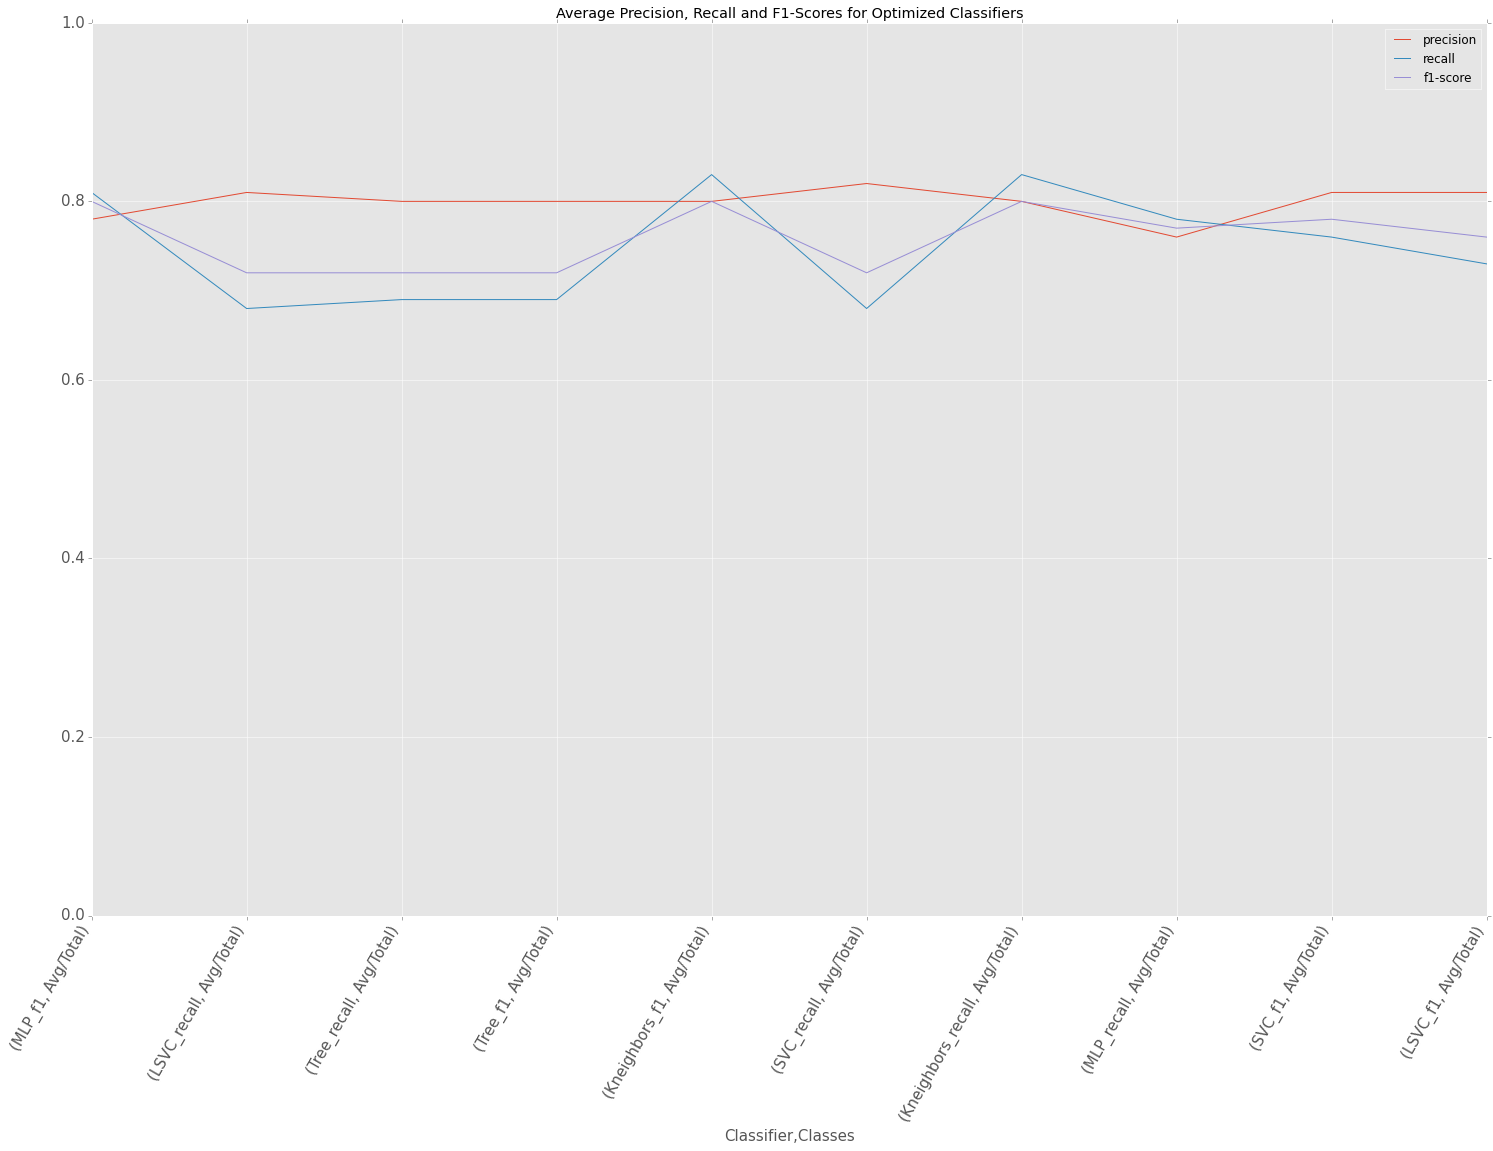

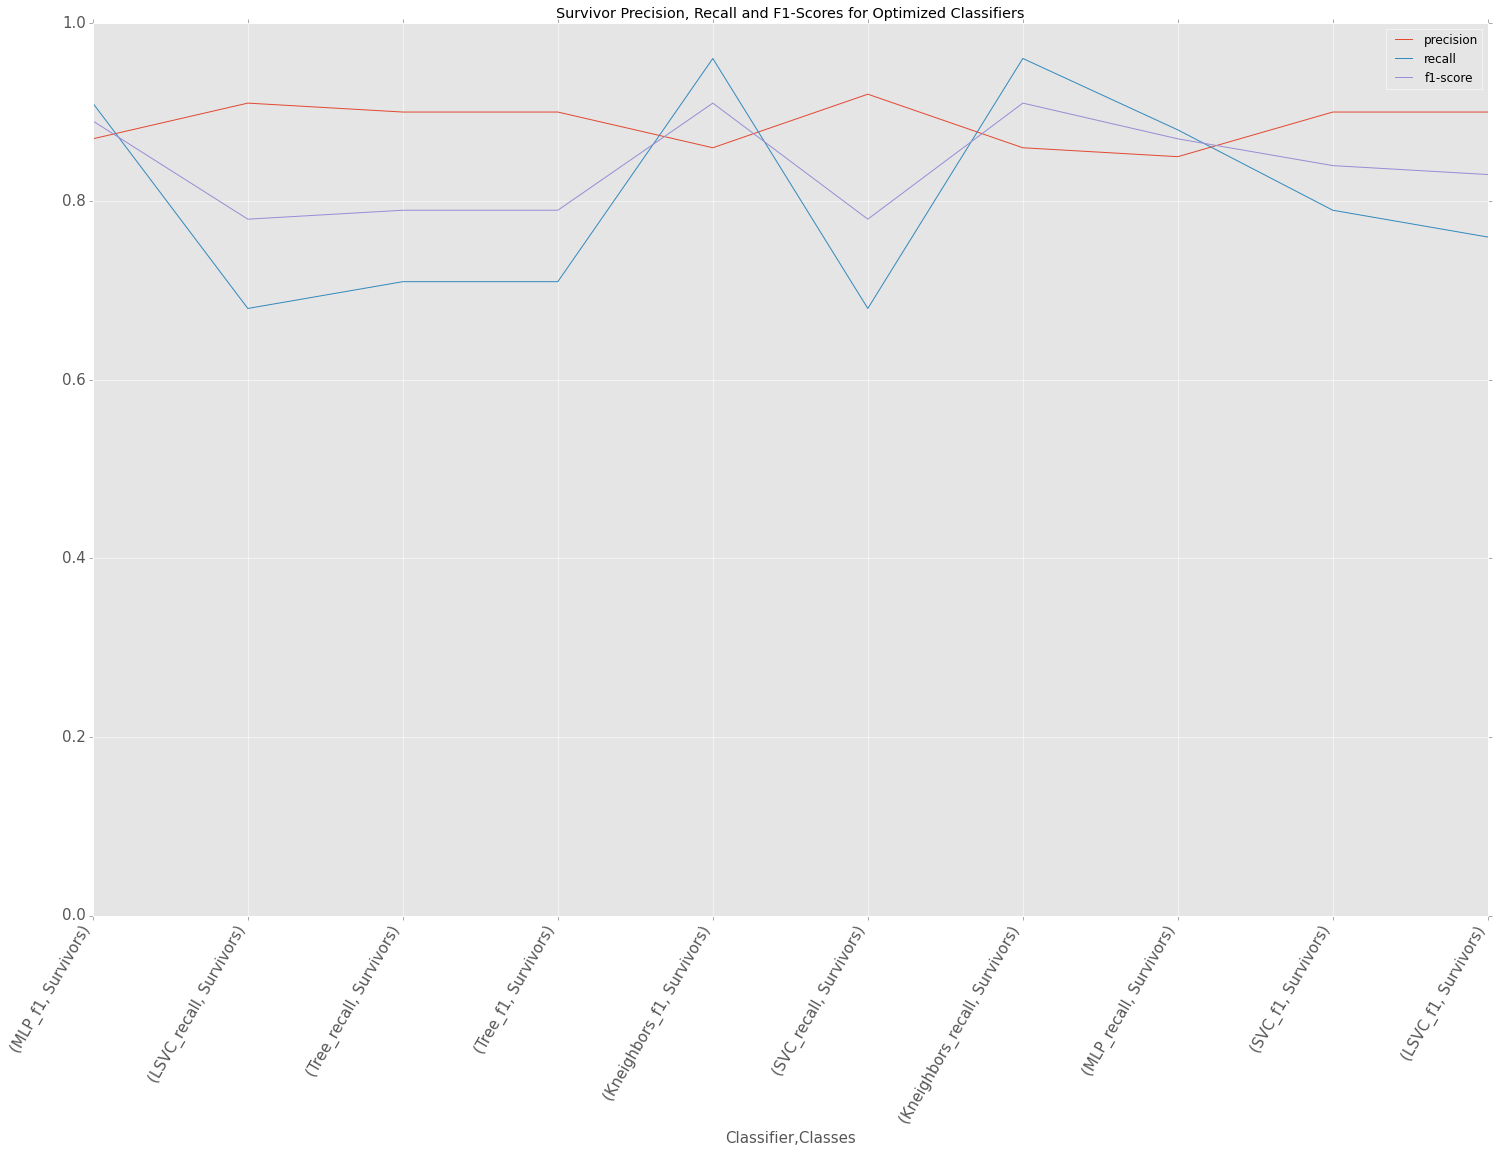

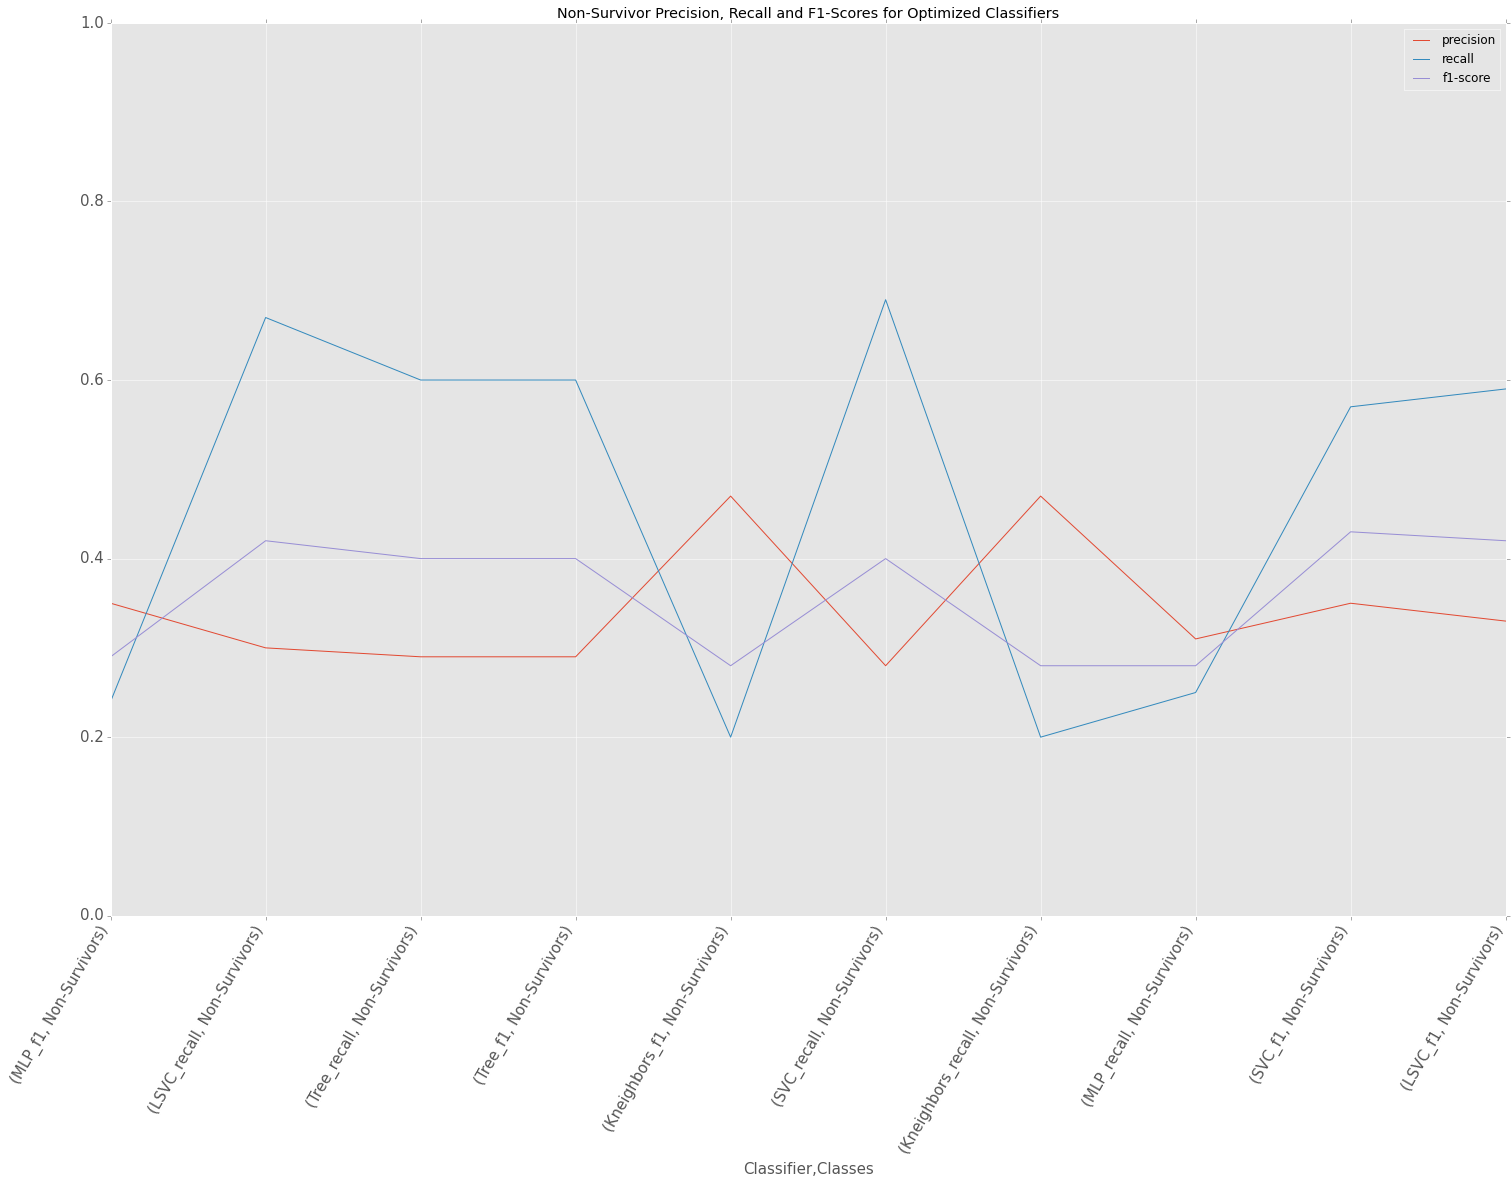

In [21]:
ax = scores_frame.iloc[scores_frame.index.get_level_values('Classes') == 'Avg/Total']\
    [['precision', 'recall', 'f1-score']].plot(
    title = 'AVG/Total Values', use_index = True, figsize= (25,16))
ax.set_ylim([0.0,1.0])
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.xticks(rotation = 60, ha = 'right')
plt.title('Average Precision, Recall and F1-Scores for Optimized Classifiers')
    
ax2 = scores_frame.iloc[scores_frame.index.get_level_values('Classes') == 'Survivors']\
[['precision', 'recall', 'f1-score']].plot(
    title = 'Survivor Values', use_index = True, figsize= (25,16))
ax2.set_ylim([0.0,1.0])
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(15)
plt.xticks(rotation = 60, ha = 'right')
plt.title('Survivor Precision, Recall and F1-Scores for Optimized Classifiers')   


ax3 = scores_frame.iloc[scores_frame.index.get_level_values('Classes') == 'Non-Survivors']\
[['precision', 'recall', 'f1-score']].plot(
    title = 'Non-Survivor Values', use_index = True, figsize= (25,16))
ax3.set_ylim([0.0,1.0])
for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
             ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(15)
plt.xticks(rotation = 60, ha = 'right')
plt.title('Non-Survivor Precision, Recall and F1-Scores for Optimized Classifiers')
#recalls[['Survivors', 'Non-Survivors', 'Metric']].plot(title = key + ': Recall Scores', 
#                                                           use_index = True, figsize = (16,6))
#plt.show()

In [22]:

scores_frame.loc[scores_frame.index.get_level_values('Classifier') == 'LSVC_recall']

precision  recall  f1-score  support
Classifier  Classes                                            
LSVC_recall Survivors           0.91    0.68      0.78   1108.0
            Non-Survivors       0.30    0.67      0.42    225.0
            Avg/Total           0.81    0.68      0.72   1333.0

In [34]:
type(Tree).__name__

'DecisionTreeClassifier'

In [24]:
# CALCULATING CROSS VALIDATION SCORES FOR HIGHEST PERFORMING BENCHMARK CLASSIFIER AND 
# HIGHEST PERFORMING OPTIMIZED CLASSIFIER

cross_val_dict = {}

print "Benchmark Decision-Tree Classifier Performance"
Tree = DecisionTreeClassifier() 
X_default = all_data[all_data.columns[1:]]
y_default = all_data['hospital_expire_flag']

X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = 0.20, random_state = 42)

#print "Cross validation score on f1 (Non-Survivors Only)"
default_scores = cross_val_score(Tree, X_train, y_train, cv = 5, scoring = 'f1')
cross_val_dict['F1 Non-Surivors: Default DecisionTree'] = default_scores
#display(default_scores) 
#print "Cross validation score on f1 (Average for Survivors and Non-Survivors)"
default_scores = cross_val_score(Tree, X_train, y_train, cv = 5, scoring = 'f1_macro')
cross_val_dict['F1 Average: Default DecisionTree'] = default_scores
#display(default_scores) 

#print "Cross validation score on recall (Non-Survivors Only)"
default_scores = cross_val_score(Tree, X_train, y_train, cv = 5, scoring = 'recall')
cross_val_dict['Recall Non-Surivors: Default DecisionTree'] = default_scores
#display(default_scores)
#print "Cross validation score on recall (Average for Survivors and Non-Survivors)"
default_scores = cross_val_score(Tree, X_train, y_train, cv = 5, scoring = 'recall_macro')
cross_val_dict['Recall Average: Default DecisionTree '] = default_scores
#display(default_scores)

                                
                                
#print "Tree fit and test score"

#display(Tree.score(X_test, y_test))
Tree.fit(X_train, y_train)
print "Tree Confusion Matrix and Classification Report"
y_preds = Tree.predict(X_test)
display(metrics.confusion_matrix(y_test, y_preds))
print metrics.classification_report(y_test, y_preds)


# PERFORMING CROSS VALIDATION ON LSVC_RECALL WITH OPTIMIZED PARAMETERS
print "Optimized LSVC Classifier Performance"
X_best = all_data[all_data.columns[1:11]]
y = all_data['hospital_expire_flag']
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = 0.50, random_state = 42)

clf = optimized_clfs['LSVC_recall']['CLF']#.best_estimator_

#print "Cross validation score on f1 (Non-Survivors Only)"
optimized_scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'f1')
cross_val_dict['F1 Non-Surivors: Optimized LSVC'] = optimized_scores
#display(optimized_scores)
#print "Cross validation score on f1 (Average for Survivors and Non-Survivors)"
optimized_scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'f1_macro')
cross_val_dict['F1 Average: Optimized LSVC'] = optimized_scores
#display(optimized_scores)

#print "Cross validation score on recall (Non-Survivors Only)"
optimized_scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'recall')
cross_val_dict['Recall Non-Survivors: Optimized LSVC'] = optimized_scores
#display(optimized_scores)
#print "Cross validation score on recall (Average for Survivors and Non-Survivors)"
optimized_scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'recall_macro')
cross_val_dict['Recall Average: Optimized LSVC'] = optimized_scores
#display(optimized_scores)


#print "LSVC fit test"
#display(scores)  

#display(clf.score(X_test, y_test))

clf.fit(X_train, y_train)
print "LSVC Confusion Matrix and Classification Report"
y_preds = clf.predict(X_test)
display(metrics.confusion_matrix(y_test, y_preds))
print metrics.classification_report(y_test, y_preds)

cross_val_df = pd.DataFrame.from_dict(cross_val_dict)
cross_cols = list(cross_val_df.columns)
cross_cols.sort()
cross_val_F1_df = cross_val_df[cross_cols[:4]]
cross_val_Recall_df = cross_val_df[cross_cols[4:]]
display(cross_val_F1_df.round(2))
display(cross_val_Recall_df.round(2))

Benchmark Decision-Tree Classifier Performance
Tree Confusion Matrix and Classification Report


array([[441,  17],
       [ 65,  10]])

             precision    recall  f1-score   support

          0       0.87      0.96      0.91       458
          1       0.37      0.13      0.20        75

avg / total       0.80      0.85      0.81       533

Optimized LSVC Classifier Performance
LSVC Confusion Matrix and Classification Report


array([[755, 353],
       [ 69, 156]])

             precision    recall  f1-score   support

          0       0.92      0.68      0.78      1108
          1       0.31      0.69      0.43       225

avg / total       0.81      0.68      0.72      1333



,F1 Average: Default DecisionTree,F1 Average: Optimized LSVC,F1 Non-Surivors: Default DecisionTree,F1 Non-Surivors: Optimized LSVC
0,0.57,0.65,0.25,0.47
1,0.58,0.58,0.25,0.39
2,0.58,0.60,0.27,0.44
3,0.52,0.60,0.15,0.39
4,0.58,0.63,0.26,0.46


,Recall Average: Default DecisionTree,Recall Average: Optimized LSVC,Recall Non-Surivors: Default DecisionTree,Recall Non-Survivors: Optimized LSVC
0,0.56,0.74,0.18,0.75
1,0.57,0.67,0.16,0.68
2,0.57,0.71,0.19,0.77
3,0.53,0.66,0.10,0.58
4,0.57,0.73,0.18,0.74


In [25]:

# CREATE DICTIONARIES FOR CROSS VALIDATION STATISTICS. WILL LATER BE CONVERTED TO DATAFRAMES

cross_val_F1_stats_dict = {}
cross_val_Recall_stats_dict = {}
cross_val_F1_stats_dict['F1 Means'] = cross_val_F1_df.mean()
cross_val_F1_stats_dict['F1 Stds'] = cross_val_F1_df.std()


# CALCULATE STATISTICS
cross_val_Recall_stats_dict['Recall Means'] = cross_val_Recall_df.mean()
cross_val_Recall_stats_dict['Recall Stds'] = cross_val_Recall_df.std()
cross_val_F1_stats_df = pd.DataFrame.from_dict(cross_val_F1_stats_dict)
cross_val_Recall_stats_df = pd.DataFrame.from_dict(cross_val_Recall_stats_dict)
display(cross_val_F1_stats_df)
display(cross_val_Recall_stats_df)

,F1 Means,F1 Stds
F1 Average: Default DecisionTree,0.566439,0.025218
F1 Average: Optimized LSVC,0.612526,0.027265
F1 Non-Surivors: Default DecisionTree,0.235586,0.048816
F1 Non-Surivors: Optimized LSVC,0.432480,0.037220


,Recall Means,Recall Stds
Recall Average: Default DecisionTree,0.559343,0.017624
Recall Average: Optimized LSVC,0.700417,0.035874
Recall Non-Surivors: Default DecisionTree,0.160200,0.037213
Recall Non-Survivors: Optimized LSVC,0.706025,0.077392


In [26]:
cross_val_F1_stats_df

,F1 Means,F1 Stds
F1 Average: Default DecisionTree,0.566439,0.025218
F1 Average: Optimized LSVC,0.612526,0.027265
F1 Non-Surivors: Default DecisionTree,0.235586,0.048816
F1 Non-Surivors: Optimized LSVC,0.432480,0.037220


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

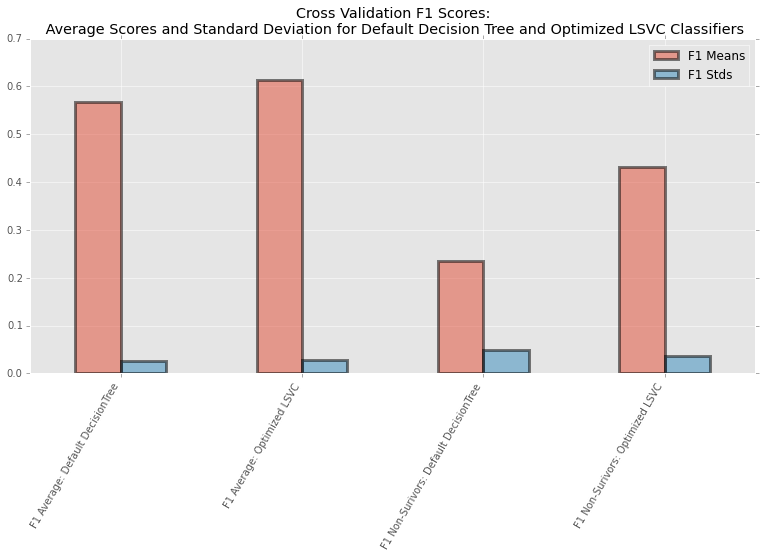

In [27]:
cross_val_F1_stats_df.plot.bar(figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Cross Validation F1 Scores: \n Average Scores and Standard Deviation for Default Decision Tree and Optimized LSVC Classifiers")

plt.xticks(rotation = 60, ha = 'right')


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

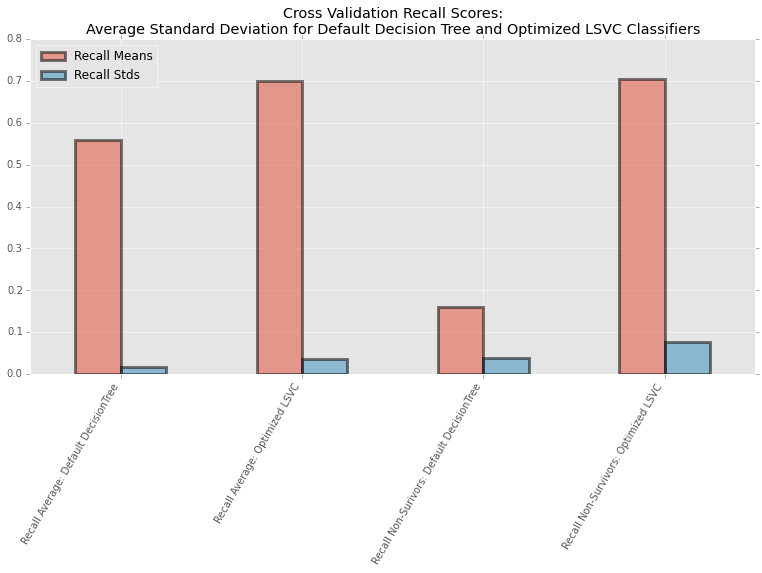

In [28]:
cross_val_Recall_stats_df.plot.bar(figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "Cross Validation Recall Scores: \nAverage Standard Deviation for Default Decision Tree and Optimized LSVC Classifiers")

plt.xticks(rotation = 60, ha = 'right')

In [29]:
def_scores

precision  recall  f1-score  support
Classifier             Classes                                            
SVC                    Survivors           0.86    1.00      0.92    458.0
                       Non-Survivors       0.00    0.00      0.00     75.0
                       Avg/Total           0.74    0.86      0.79    533.0
KNeighborsClassifier   Survivors           0.87    0.94      0.90    458.0
                       Non-Survivors       0.31    0.17      0.22     75.0
                       Avg/Total           0.79    0.83      0.81    533.0
LinearSVC              Survivors           0.87    0.98      0.92    458.0
                       Non-Survivors       0.48    0.13      0.21     75.0
                       Avg/Total           0.82    0.86      0.82    533.0
MLPClassifier          Survivors           0.88    0.95      0.91    458.0
                       Non-Survivors       0.39    0.20      0.27     75.0
                       Avg/Total           0.81    0.84      0.82    533.0
DecisionTreeClassifier Survivors           0.89    0.89      0.89    458.0
                       Non-Survivors       0.33    0.33      0.33     75.0
                       Avg/Total           0.81    0.81      0.81    533.0

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

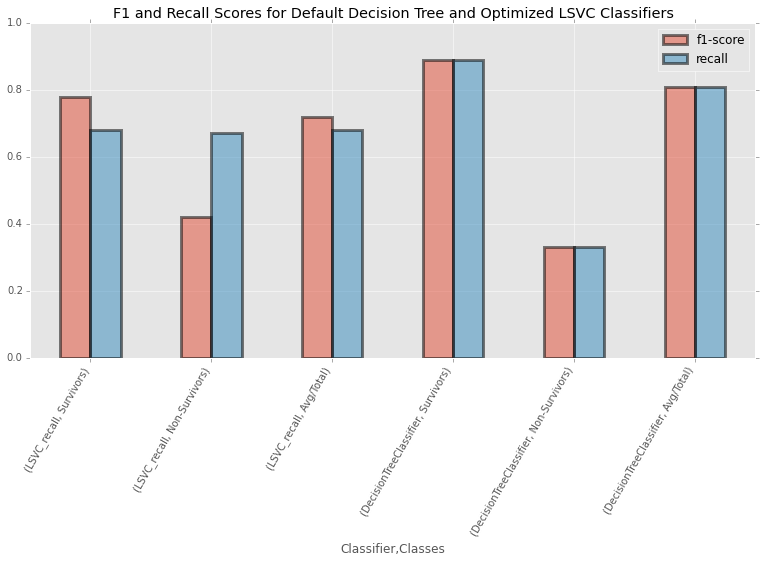

In [30]:
LSVC_df = scores_frame.loc[scores_frame.index.get_level_values('Classifier') == 'LSVC_recall']
LSVC_DTC_df = LSVC_df.append(def_scores.loc[def_scores.index.get_level_values('Classifier') == 'DecisionTreeClassifier'])


LSVC_DTC_df[['f1-score', 'recall']].plot.bar(figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "F1 and Recall Scores for Default Decision Tree and Optimized LSVC Classifiers")

plt.ylim(0,1)
plt.xticks(rotation = 60, ha = 'right')

## PLOT DEFAULT VS OPTIMIZED LSVC CLASSIFIER SCORES

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

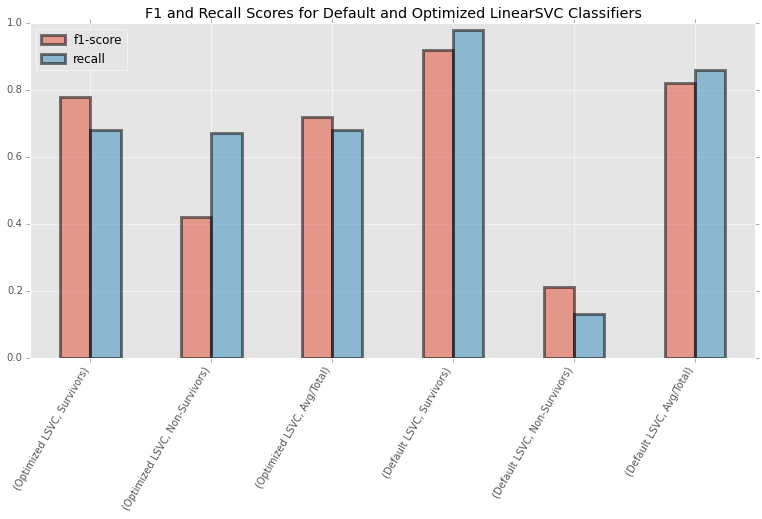

In [31]:
LSVC_df2 = scores_frame.loc[scores_frame.index.get_level_values('Classifier') == 'LSVC_recall']
LSVC_df2 = LSVC_df2.append(def_scores.loc[def_scores.index.get_level_values('Classifier') == 'LinearSVC'])

ind = ['Survivors', 'Non-Survivors', 'Avg/Total']
    # CLEAN THIS UP
arrays = [['Optimized LSVC', 'Optimized LSVC', 'Optimized LSVC',
               'Default LSVC','Default LSVC','Default LSVC'], 
              ['Survivors', 'Non-Survivors', 'Avg/Total', 'Survivors', 'Non-Survivors', 'Avg/Total']]
    
mindex = pd.MultiIndex.from_arrays(arrays, names=['Classifier', 'Classes'])

monkey_df = LSVC_df2.copy()

LSVC_df3 = monkey_df.set_index(arrays)

LSVC_df3[['f1-score', 'recall']].plot.bar(figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                alpha = 0.5, title = "F1 and Recall Scores for Default and Optimized LinearSVC Classifiers")


plt.xticks(rotation = 60, ha = 'right')

# *fin*